In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats, signal
from neo import SpikeTrain

import ast
import h5py
import json
import os
import sys

In [2]:
# Import helper
sys.path.append("../")

from helpers import helper_funcs
# Reloads if changes happens
from importlib import reload
reload(helper_funcs)

<module 'helpers.helper_funcs' from 'C:\\Users\\hakon\\Skole\\NMBU_8\\Masteroppgave\\masteroppgave-data-2023\\figures\\..\\helpers\\helper_funcs.py'>

In [3]:
# Set style todo: update?
sns.set(context="paper", font_scale=1.5, style='darkgrid')

# Save plot
SAVE_PLOT = False

In [4]:
# Plots prior disitribution (uniform)
def plot_prior(min_val, max_val, x_label, obs_value, ax, N=10000, solid_line=False, color=None, fontsize=11, set_legend=True):
    """Plots prior distribution of the first simulation (uniform)"""
    # Min and max value of synapse weight (from github simulation)

    scale = np.abs(min_val - max_val) * 0.2

    # Distribution calculator
    # todo remove: Distributions (ee = exhitatory to exhitatory, ie = exhitatory to inhibitory etc.)
    distribution = stats.uniform(loc=min_val, scale=(max_val - min_val))

    # weight_values to evaluate distribution
    xs = np.linspace(min_val - scale, max_val + scale, num=N)

    # Make different colors
    if color:
        ax.plot(xs, distribution.pdf(xs), color=color)
        ax.fill_between(xs, distribution.pdf(xs), color=color, alpha=.5)
        ax.set_xlabel(x_label)
        
    elif x_label[-1].lower() == "e":  # make positive values same color'
        ax.plot(xs, distribution.pdf(xs))
        ax.fill_between(xs, distribution.pdf(xs), alpha=.5)
        ax.set_xlabel(x_label)
    else:
        ax.plot(xs, distribution.pdf(xs), color="C1")
        ax.fill_between(xs, distribution.pdf(xs), color="C1", alpha=.5)
        ax.set_xlabel(x_label)
        
    # Plot true observation
    y_coord = np.max(distribution.pdf(obs_value))
    if solid_line:
        ax.vlines(x=obs_value, ymin=0, ymax=y_coord, ls="-", color="black", label=rf"$\theta_{{true}}$: {obs_value:.3}")
    else:
        ax.vlines(x=obs_value, ymin=0, ymax=y_coord, ls="--", color="black", label=rf"$\theta_{{true}}$: {obs_value:.3}")
    
    if set_legend:
        ax.legend(loc="upper left", fontsize=fontsize)

In [5]:
# Parameter names
param_names = ["g_ee", "g_ie","g_ei", "g_ii"]
summary_stat_names = ["mean_firing_rate_inhibitory",
                      "mean_firing_rate_excitatory",
                      "fanofactor_inhibitory",
                      "fanofactor_excitatory",
                      "mean_interspike_interval_inhibitory",
                      "mean_interspike_interval_excitatory",
                      "mean_cv_inhibitory",
                      "mean_cv_excitatory"]

# For plotting of uniform priors
min_max_dict = {"e": {"min_value": 0.5, "max_value": 2.0}, 
                "i": {"min_value": -16.0, "max_value": -2.25}}

In [6]:
# Base observation
df_obs_base = helper_funcs.load_file("../2pop/data/obs/2pop_observation_base")
obs_hist_base = helper_funcs.load_file("../2pop/data/obs/2pop_observation_histogram_base")

# Samples used to create final observation metrics
df_obs_samples = helper_funcs.load_file("../2pop/data/obs/2pop_observation_samples")
obs_hist_samples = helper_funcs.load_file("../2pop/data/obs/2pop_observation_histogram_samples")

# Final observation
df_obs = helper_funcs.load_file("../2pop/data/2pop_observation")
obs_hist = helper_funcs.load_file("../2pop/data/2pop_observation_histogram")

#### Posterior distributions

In [7]:
# Posteriors from simulation 0 (initial with uniform priors)
df_abc_regression_posterior_0 = helper_funcs.load_file("../2pop/abc/abc_data/sim_0/regression/2pop_df_abc_regression_params_0")
df_sbi_simple_posterior_0 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/simple/2pop_df_sbi_simple_params_0")
df_sbi_embedding_posterior_0 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/embedding/2pop_df_sbi_embedding_params_0")

In [8]:
# Posteriors from simulation 1 (with posteriors from simulation 0 as priors)
df_abc_regression_posterior_1 = helper_funcs.load_file("../2pop/abc/abc_data/sim_1/regression/2pop_df_abc_regression_params_1")
df_sbi_simple_posterior_1 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/simple/2pop_df_sbi_simple_params_1")
df_sbi_embedding_posterior_1 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/embedding/2pop_df_sbi_embedding_params_1")

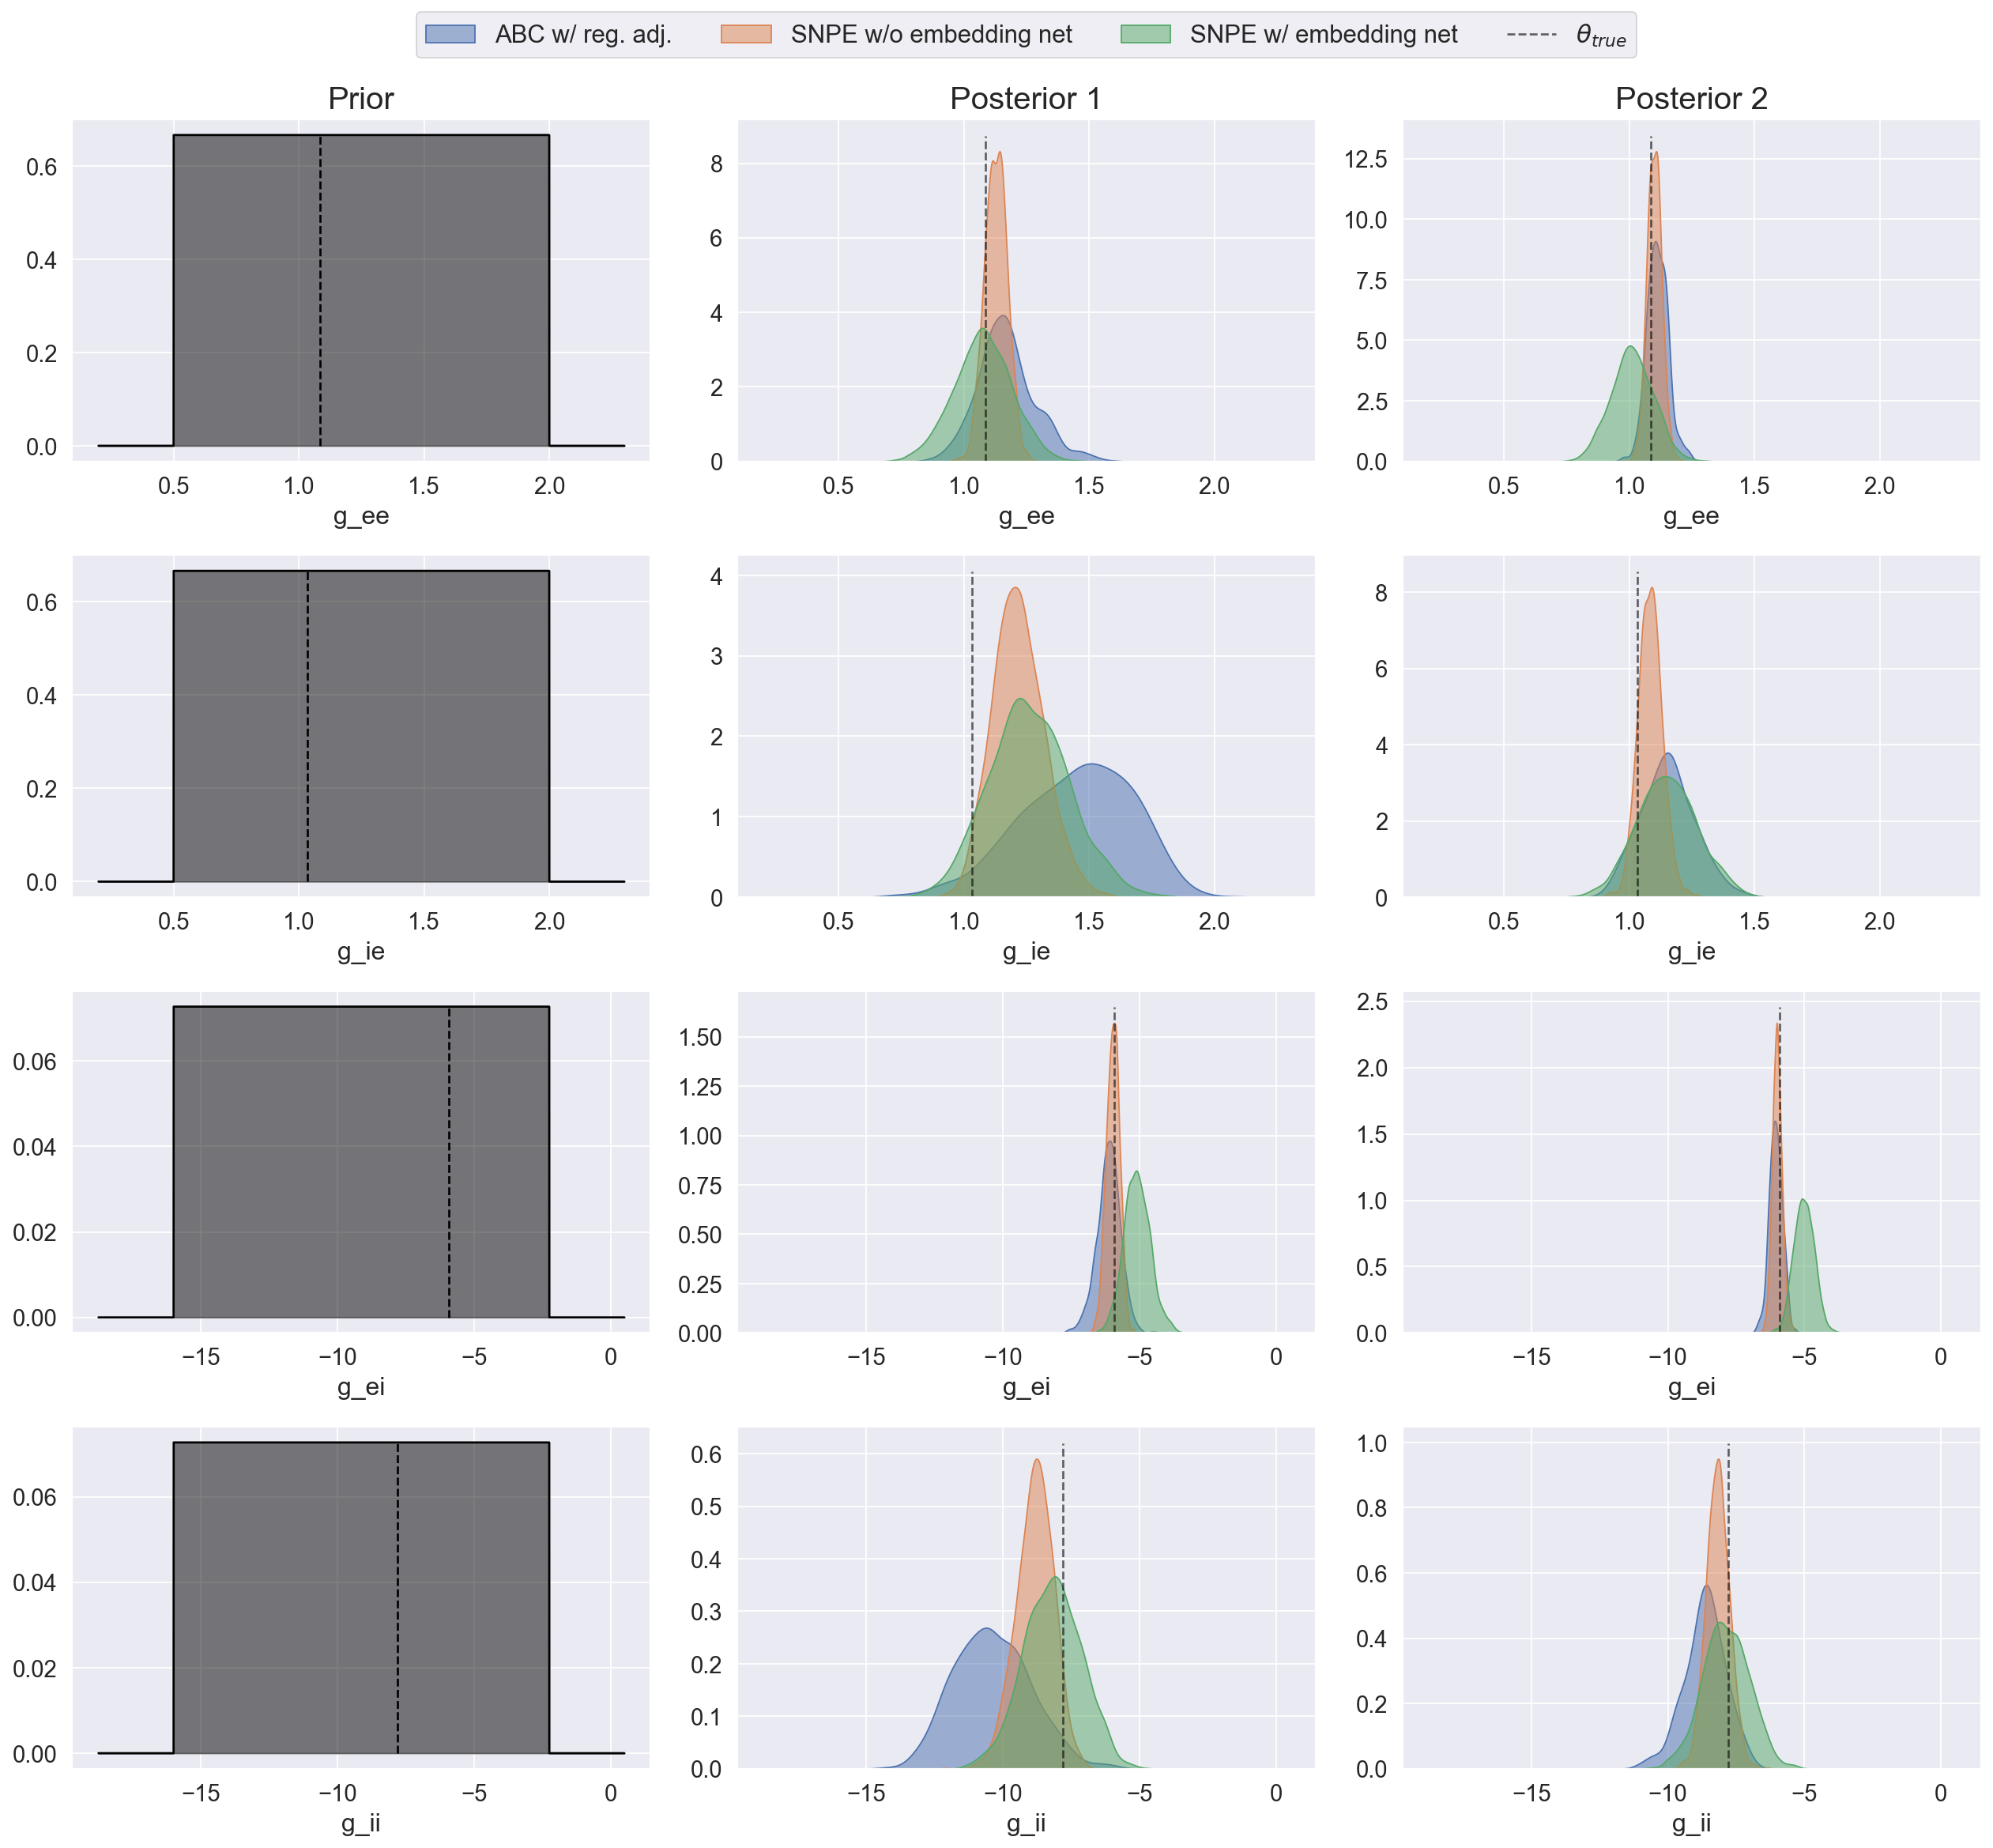

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(16, 14), sharex="row", dpi=160)
fig.subplots_adjust(wspace=-1.2, hspace=0.5)
alpha_value_posteriors = 0.5
bbox=("upper left", (0., 1.))
ylabel = None
label_size = 14

for row in range(4):
    
    # abc_regression_posterior_distribution_0 = stats.gaussian_kde(df_abc_regression_posterior_0[param_names[row]])
    # sbi_simple_posterior_distribution_0 = stats.gaussian_kde(df_sbi_simple_posterior_0[param_names[row]])
    # sbi_embedding_posterior_distribution_0 = stats.gaussian_kde(df_sbi_embedding_posterior_0[row])
    # todo: could do posterior_distribution.resample(#number) - would this be correct?

    # True theta value
    theta_true = float(df_obs[param_names[row]])
    
    ## Ax column 1
    # Prior
    plot_prior(min_val=min_max_dict[param_names[row][-1]]["min_value"], 
               max_val=min_max_dict[param_names[row][-1]]["max_value"],
               x_label=param_names[row], 
               obs_value=float(df_obs[param_names[row]]), 
               ax=ax[row, 0], 
               solid_line=False, 
               color="black", 
               fontsize=label_size, 
               set_legend=False)
    
    
    ## Ax column 2
    # Posteriors ABC with regression adjustment from simulation 0
    sns.kdeplot(data=df_abc_regression_posterior_0, 
                x=param_names[row], 
                ax=ax[row, 1], 
                fill=True, 
                alpha=alpha_value_posteriors, label="ABC w/ reg. adj.")
    
    # Posteriors SNPE without embedding net (simple) from simulation 0
    sns.kdeplot(data=df_sbi_simple_posterior_0, 
                x=param_names[row], 
                ax=ax[row, 1], 
                fill=True, 
                alpha=alpha_value_posteriors, 
                label="SNPE w/o embedding net")
    
    # Posteriors SNPE with embedding net from simulation 0
    sns.kdeplot(data=df_sbi_embedding_posterior_0, 
                x=param_names[row], 
                ax=ax[row, 1], 
                fill=True, 
                alpha=alpha_value_posteriors, 
                label="SNPE w/ embedding net")
    
    # Ax specifics
    ymin, ymax = ax[row, 1].get_ylim()
    # ax[row, 1].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
    #                   label=rf"$\theta_{{true}}$: {theta_true:.3}", alpha=0.6, ls="--")
    ax[row, 1].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
                      label=rf"$\theta_{{true}}$", alpha=0.6, ls="--")
    #ax[row, 1].legend(loc=bbox[0], fontsize=label_size)
    ax[row, 1].set_ylabel(ylabel)
    
    
    ## Ax column 3
    # Posterior ABC from simulation 1
    sns.kdeplot(data=df_abc_regression_posterior_1, 
                x=param_names[row], 
                ax=ax[row, 2], 
                fill=True, 
                alpha=alpha_value_posteriors, 
                label="ABC w/ reg. adj.")
    
    # Posterior SBI novel from simulation 0
    sns.kdeplot(data=df_sbi_simple_posterior_1, 
                x=param_names[row], 
                ax=ax[row, 2], fill=True, 
                alpha=alpha_value_posteriors, 
                label="SBI w/o embedding net")
    
    # Posterior SBI embedding from simulation 1
    sns.kdeplot(data=df_sbi_embedding_posterior_1, 
                x=param_names[row], 
                ax=ax[row, 2], fill=True, 
                alpha=alpha_value_posteriors, 
                label="SBI w/ embedding net")
    
    # Ax specifics
    ymin, ymax = ax[row, 2].get_ylim()
    # ax[row, 2].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
    #                   label=rf"$\theta_{{true}}$: {theta_true:.3}", alpha=0.6, ls="--")
    ax[row, 2].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
                      label=rf"$\theta_{{true}}$", alpha=0.6, ls="--")
    #ax[row, 2].legend(loc=bbox[0], fontsize=label_size)
    ax[row, 2].set_ylabel(ylabel)

plt.tight_layout()
# Titles
ax[0, 0].set_title("Prior", size=18)
ax[0, 1].set_title("Posterior 1", size=18)
ax[0, 2].set_title("Posterior 2", size=18)
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.35), ncol=4, fontsize=label_size)

#fig.subplots_adjust(bottom=-0.15)

if SAVE_PLOT:
    save_path = "./for_thesis/results/posterior_distributions.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

#### Summary statistics comparison

##### Outliers

In [10]:
# ABC regression
df_final_simulation_abc_regression = helper_funcs.load_file("../2pop/data/sim_2/abc_regression/2pop_simulations_2")
df_final_simulation_abc_regression.head()

# Remove samples with std < -5 and > 5
mask_abc_reg = (stats.zscore(df_final_simulation_abc_regression[summary_stat_names]) > -5).all(axis=1) & \
               (stats.zscore(df_final_simulation_abc_regression[summary_stat_names]) < 5).all(axis=1)

# Indexes to drop
drop_index_abc = np.where(mask_abc_reg.values == False)[0]

# final df without outliers (removed: 1)
df_final_simulation_abc_regression_filtered = df_final_simulation_abc_regression.drop(axis=0, index=drop_index_abc).reset_index()

In [11]:
# SBI with embedding net
df_final_simulation_sbi_embedding = helper_funcs.load_file("../2pop/data/sim_2/sbi_embedding/2pop_simulations_2")


# Mask it
# Remove samples with std < -5 and > 5
mask_sbi_embedding = (stats.zscore(df_final_simulation_sbi_embedding[summary_stat_names]) > -5).all(axis=1) & \
                     (stats.zscore(df_final_simulation_sbi_embedding[summary_stat_names]) < 5).all(axis=1)

# indexes to drop
drop_index_embedding = np.where(mask_sbi_embedding.values == False)[0]

# Final df without outliers (removed: 0) No dropping needed in final version
df_final_simulation_sbi_embedding_masked = df_final_simulation_sbi_embedding.drop(axis=0, index=drop_index_embedding).reset_index()

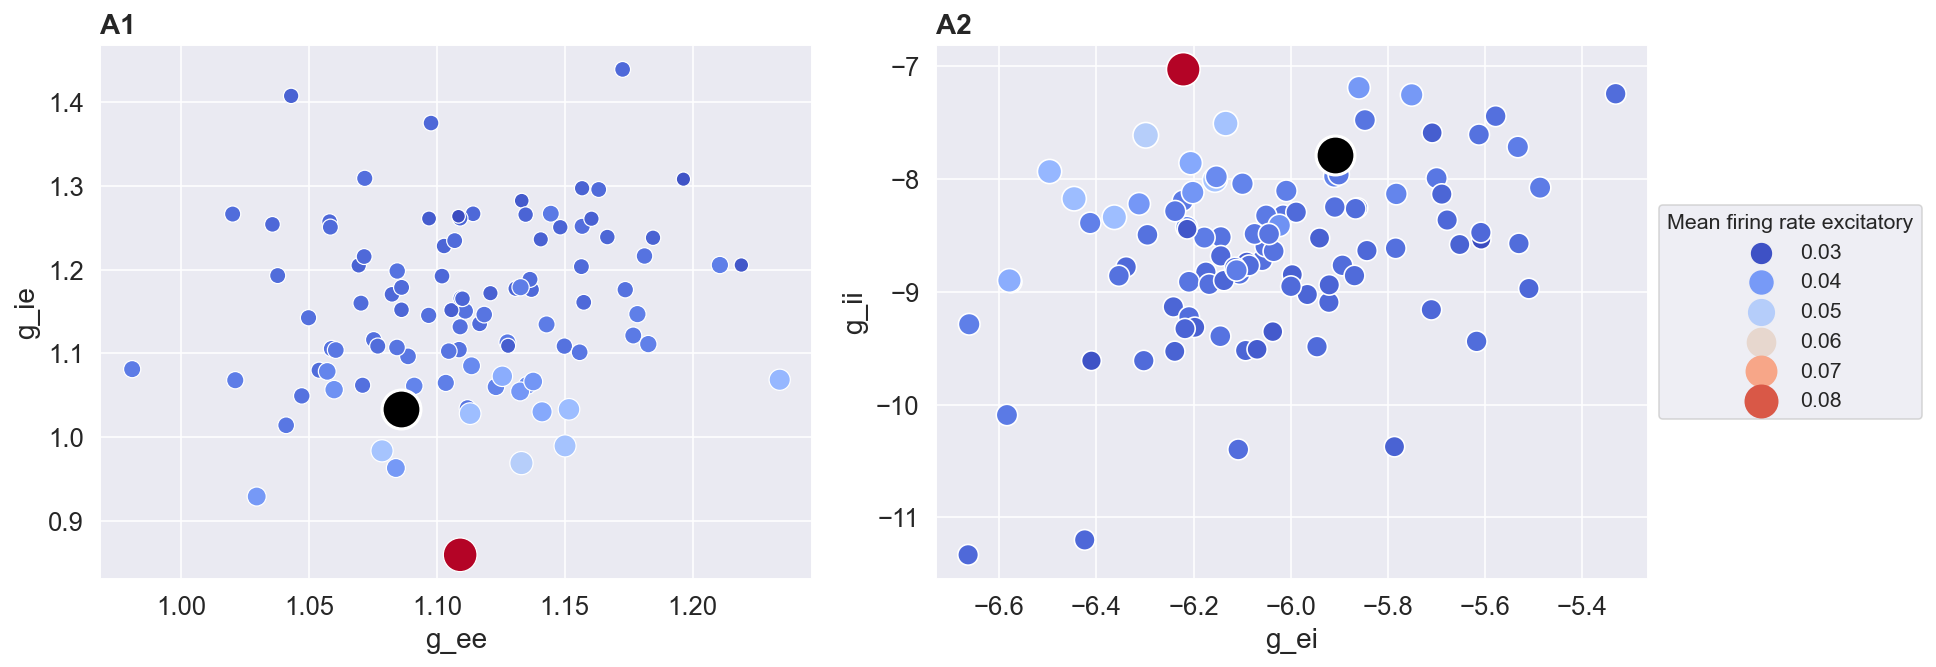

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=140, sharex="col", sharey="col")
#plt.figure(figsize=(14, 8))

# ABC regression
sns.scatterplot(x=df_final_simulation_abc_regression["g_ee"], 
                y=df_final_simulation_abc_regression["g_ie"], 
                hue=df_final_simulation_abc_regression["mean_firing_rate_excitatory"], palette="coolwarm", ax=ax[0], legend=False,
                size=df_final_simulation_abc_regression["mean_firing_rate_excitatory"], sizes=(50, 300))

sns.scatterplot(x=df_final_simulation_abc_regression["g_ei"], 
                y=df_final_simulation_abc_regression["g_ii"], 
                hue=df_final_simulation_abc_regression["mean_firing_rate_excitatory"], palette="coolwarm", ax=ax[1], legend=True,
                size=df_final_simulation_abc_regression["mean_firing_rate_excitatory"], sizes=(100, 300))

# True observation for ABC plot
sns.scatterplot(x=df_obs["g_ee"], y=df_obs["g_ie"], color="black", marker="o", s=400, ax=ax[0])
sns.scatterplot(x=df_obs["g_ei"], y=df_obs["g_ii"], color="black", marker="o", s=400, ax=ax[1])

# Set legend to the right
ax[1].legend(loc="right", bbox_to_anchor=(1.4, 0.5), title="Mean firing rate excitatory", fontsize=11, title_fontsize=11)

ax[0].set_title("A1", loc="left", fontweight="bold")
ax[1].set_title("A2", loc="left", fontweight="bold")


plt.tight_layout()

if SAVE_PLOT:
    save_path = "./for_thesis/results/outlier_scatterplot.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

##### ABC with regression adjustment

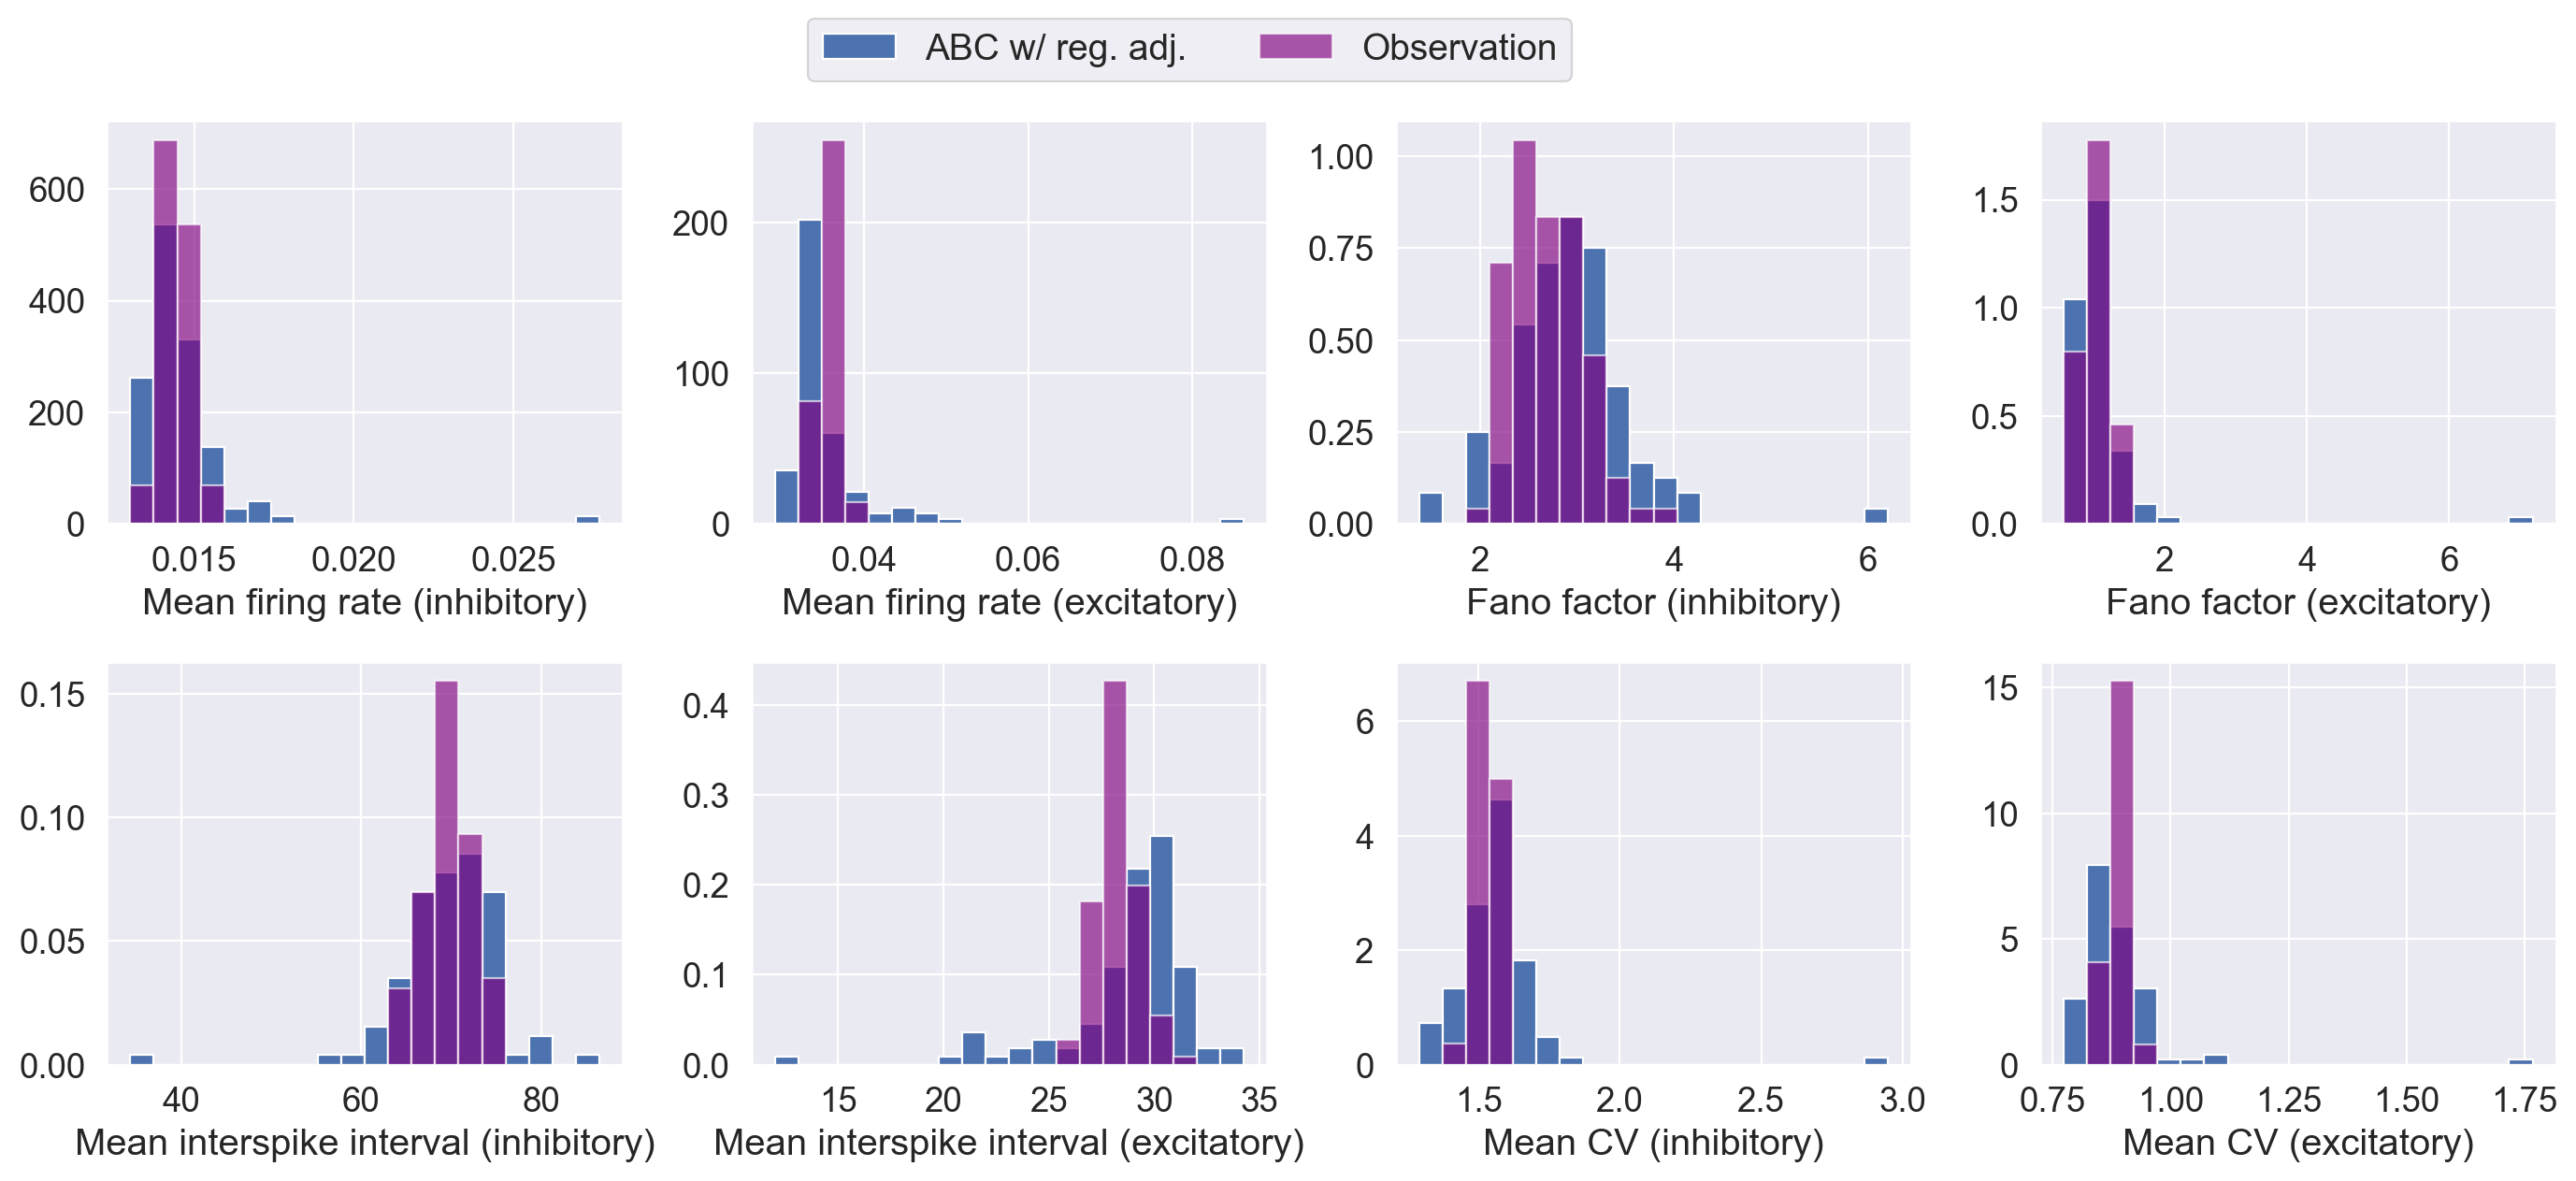

In [13]:
cols = 4
rows = 2
bins_count = 20
alpha=0.65

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_obs.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        # Get bin sizes
        data_min = min(df_final_simulation_abc_regression[sumstat_names[sumstat_idx]].min(),
                       df_obs_samples[sumstat_names[sumstat_idx]].min())
        data_max = max(df_final_simulation_abc_regression[sumstat_names[sumstat_idx]].max(),
                       df_obs_samples[sumstat_names[sumstat_idx]].max())
        bins = np.linspace(data_min, data_max, bins_count + 1)
        
        # ABC regression
        ax[row, col].hist(df_final_simulation_abc_regression[sumstat_names[sumstat_idx]], 
                          label="ABC w/ reg. adj.", 
                          alpha=1.0, 
                          bins=bins, 
                          color="C0", 
                          density=True)
        
        # ABC regression
        #ax[row, col].hist(df_final_simulation_abc_regression_filtered[sumstat_names[sumstat_idx]], label="ABC w/ adj. z-score", alpha=alpha, bins=bins, color="C1")
        
        # SNPE with MAF using handcrafted summary statistics
        #ax[row, col].hist(df_final_simulation_sbi_simple[sumstat_names[sumstat_idx]], label="SNPE novel", alpha=alpha, bins=bins, color="C2")
        
        # Target distribution
        ax[row, col].hist(df_obs_samples[sumstat_names[sumstat_idx]], 
                          label="Observation", 
                          alpha=alpha, 
                          bins=bins, 
                          color="purple", 
                          density=True)
        
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]])
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1

plt.tight_layout()
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.85, 1.3), ncol=2, fontsize=label_size)

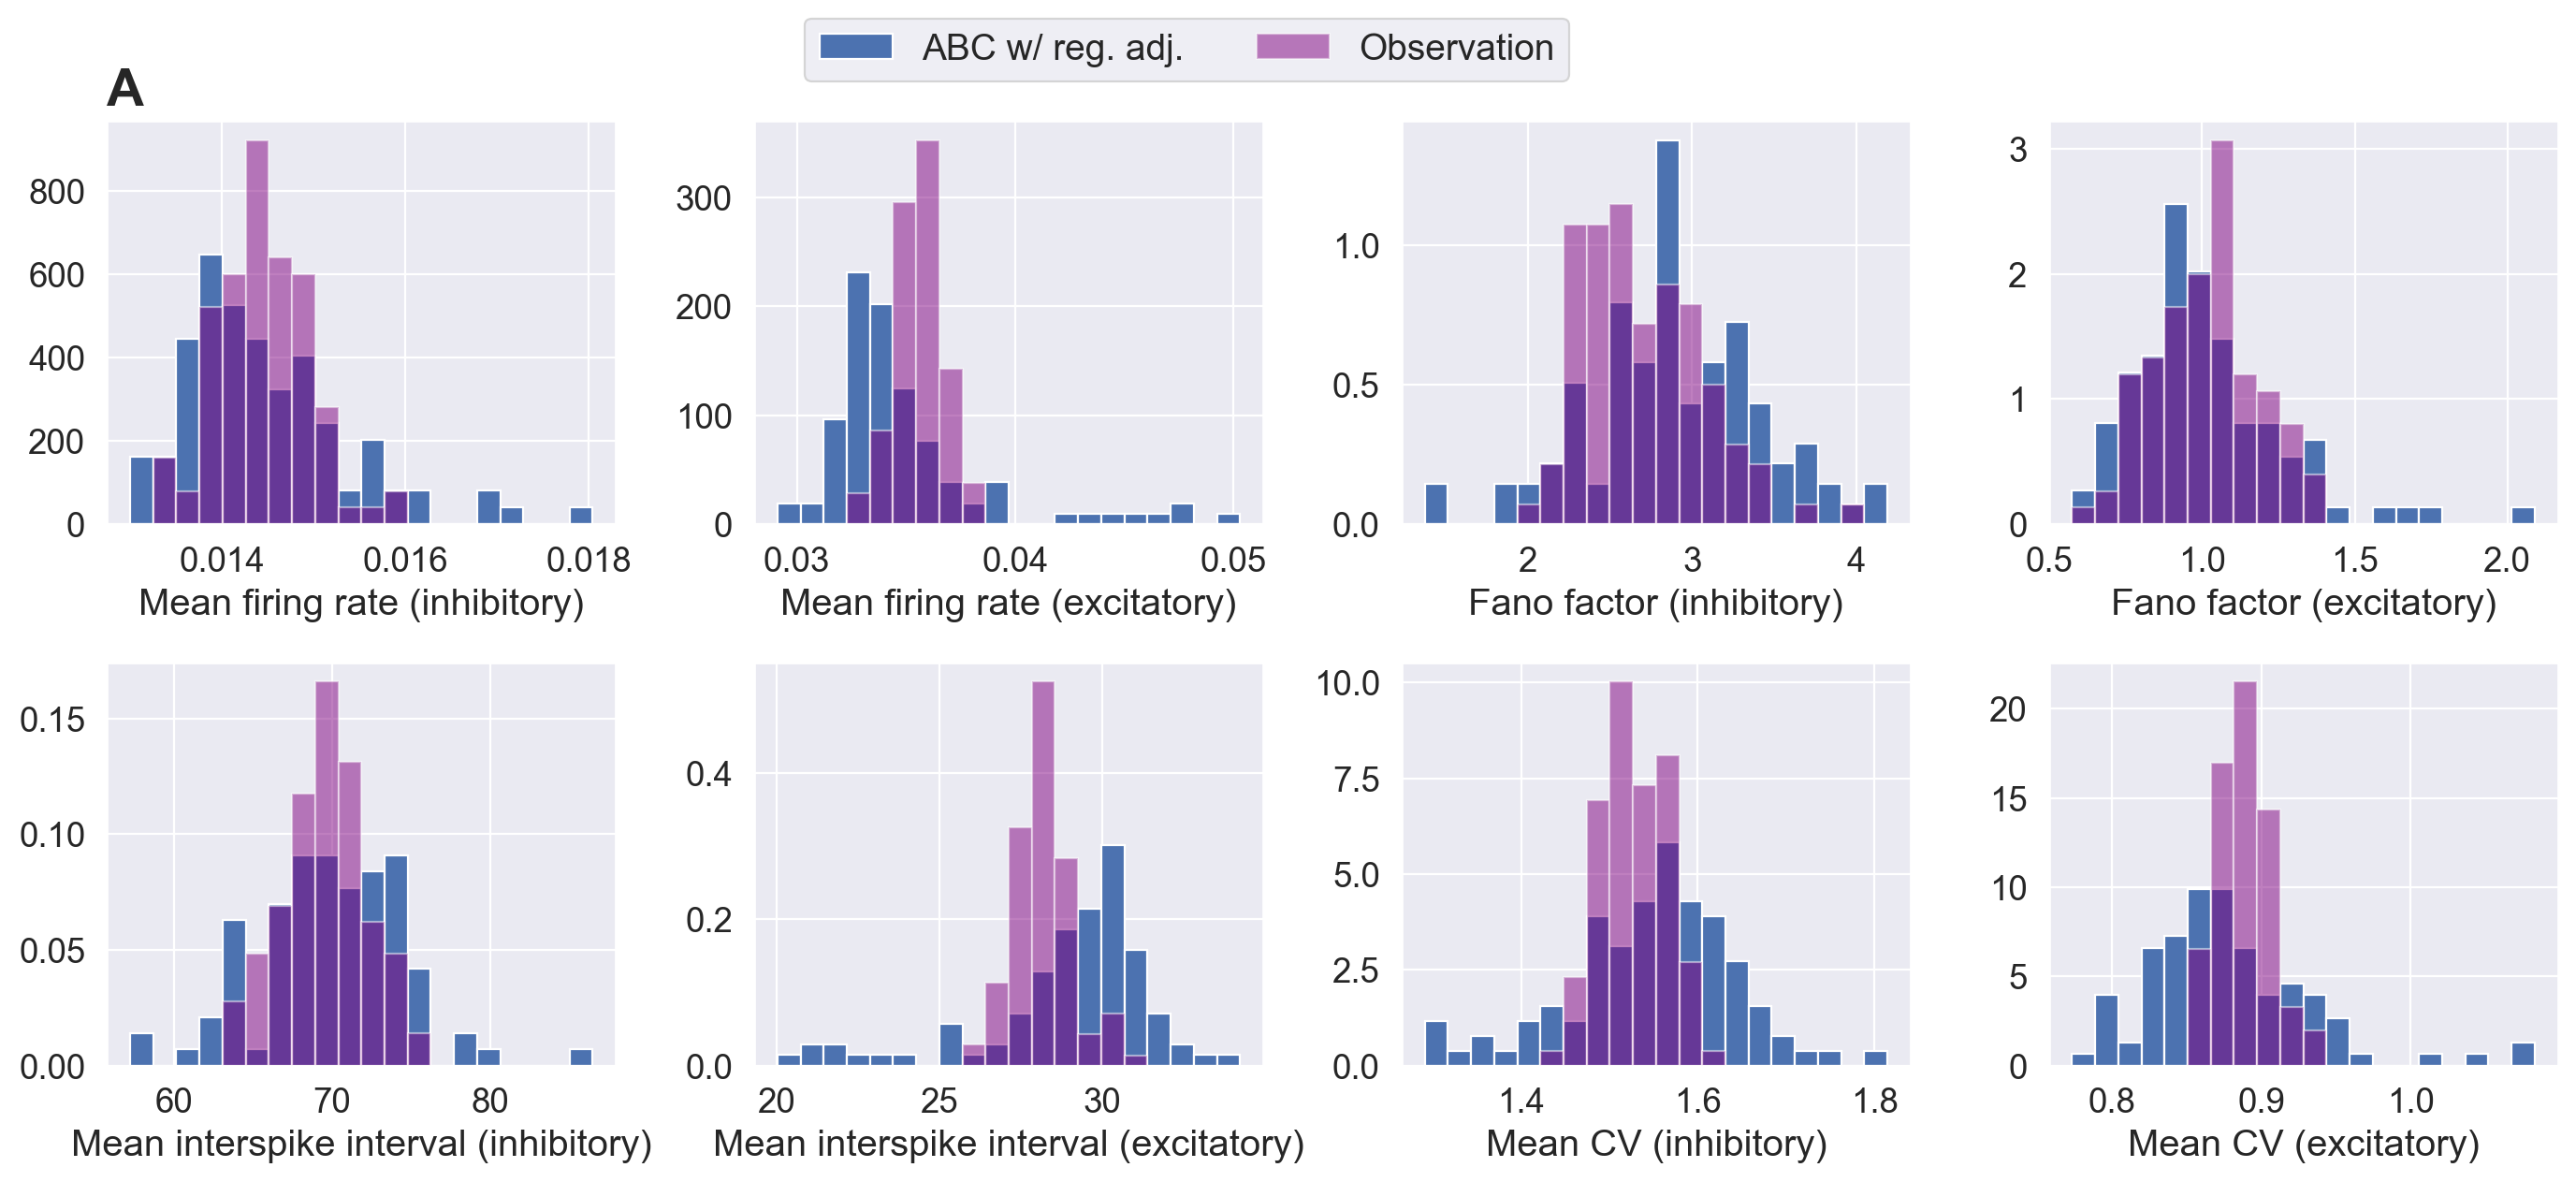

In [14]:
cols = 4
rows = 2
bins_count = 20
alpha=0.5
label_size=14

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_obs.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        # Get bin sizes
        data_min = min(df_final_simulation_abc_regression_filtered[sumstat_names[sumstat_idx]].min(),
                       df_obs_samples[sumstat_names[sumstat_idx]].min())
        data_max = max(df_final_simulation_abc_regression_filtered[sumstat_names[sumstat_idx]].max(),
                       df_obs_samples[sumstat_names[sumstat_idx]].max())
        bins = np.linspace(data_min, data_max, bins_count + 1)
        
        # ABC regression
        ax[row, col].hist(df_final_simulation_abc_regression_filtered[sumstat_names[sumstat_idx]], 
                          bins=bins, 
                          label="ABC w/ reg. adj.", 
                          alpha=1.0, 
                          color="C0", 
                          density=True)
        
        # Target distribution
        ax[row, col].hist(df_obs_samples[sumstat_names[sumstat_idx]], 
                          label="Observation", 
                          alpha=alpha, 
                          bins=bins, 
                          color="purple", 
                          density=True)
        
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]])
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1

plt.tight_layout()
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.85, 1.3), ncol=10, fontsize=label_size)
ax[0, 0].set_title("A", size=20, loc="left", fontweight="bold")

if SAVE_PLOT:
    save_path = "./for_thesis/results/abc_regression_final_sumstats.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

##### SNPE without embedding net

In [15]:
# ABC regression
df_final_simulation_sbi_simple = helper_funcs.load_file("../2pop/data/sim_2/sbi_simple/2pop_simulations_2")
df_final_simulation_sbi_simple.head()

,g_ee,g_ei,g_ie,g_ii,mean_firing_rate_inhibitory,mean_firing_rate_excitatory,fanofactor_inhibitory,fanofactor_excitatory,mean_interspike_interval_inhibitory,mean_interspike_interval_excitatory,mean_cv_inhibitory,mean_cv_excitatory
0,1.102058,-5.890253,1.031349,-7.619215,0.013930,0.035025,3.321622,1.033940,74.630207,28.524188,1.503042,0.881682
1,1.076506,-5.898696,1.074881,-8.093959,0.013830,0.034150,2.268416,0.927526,70.962293,29.487274,1.444028,0.858095
2,1.076124,-5.714609,1.038089,-7.597902,0.014860,0.034150,3.055908,0.774085,68.252785,29.234925,1.586370,0.851087
3,1.116204,-5.898422,1.059736,-7.761714,0.016405,0.037190,3.117156,1.227690,62.678409,26.993628,1.542871,0.931730
4,1.084033,-5.991750,1.066287,-8.183565,0.014535,0.035130,3.214486,0.786968,69.278980,28.554079,1.490285,0.858694


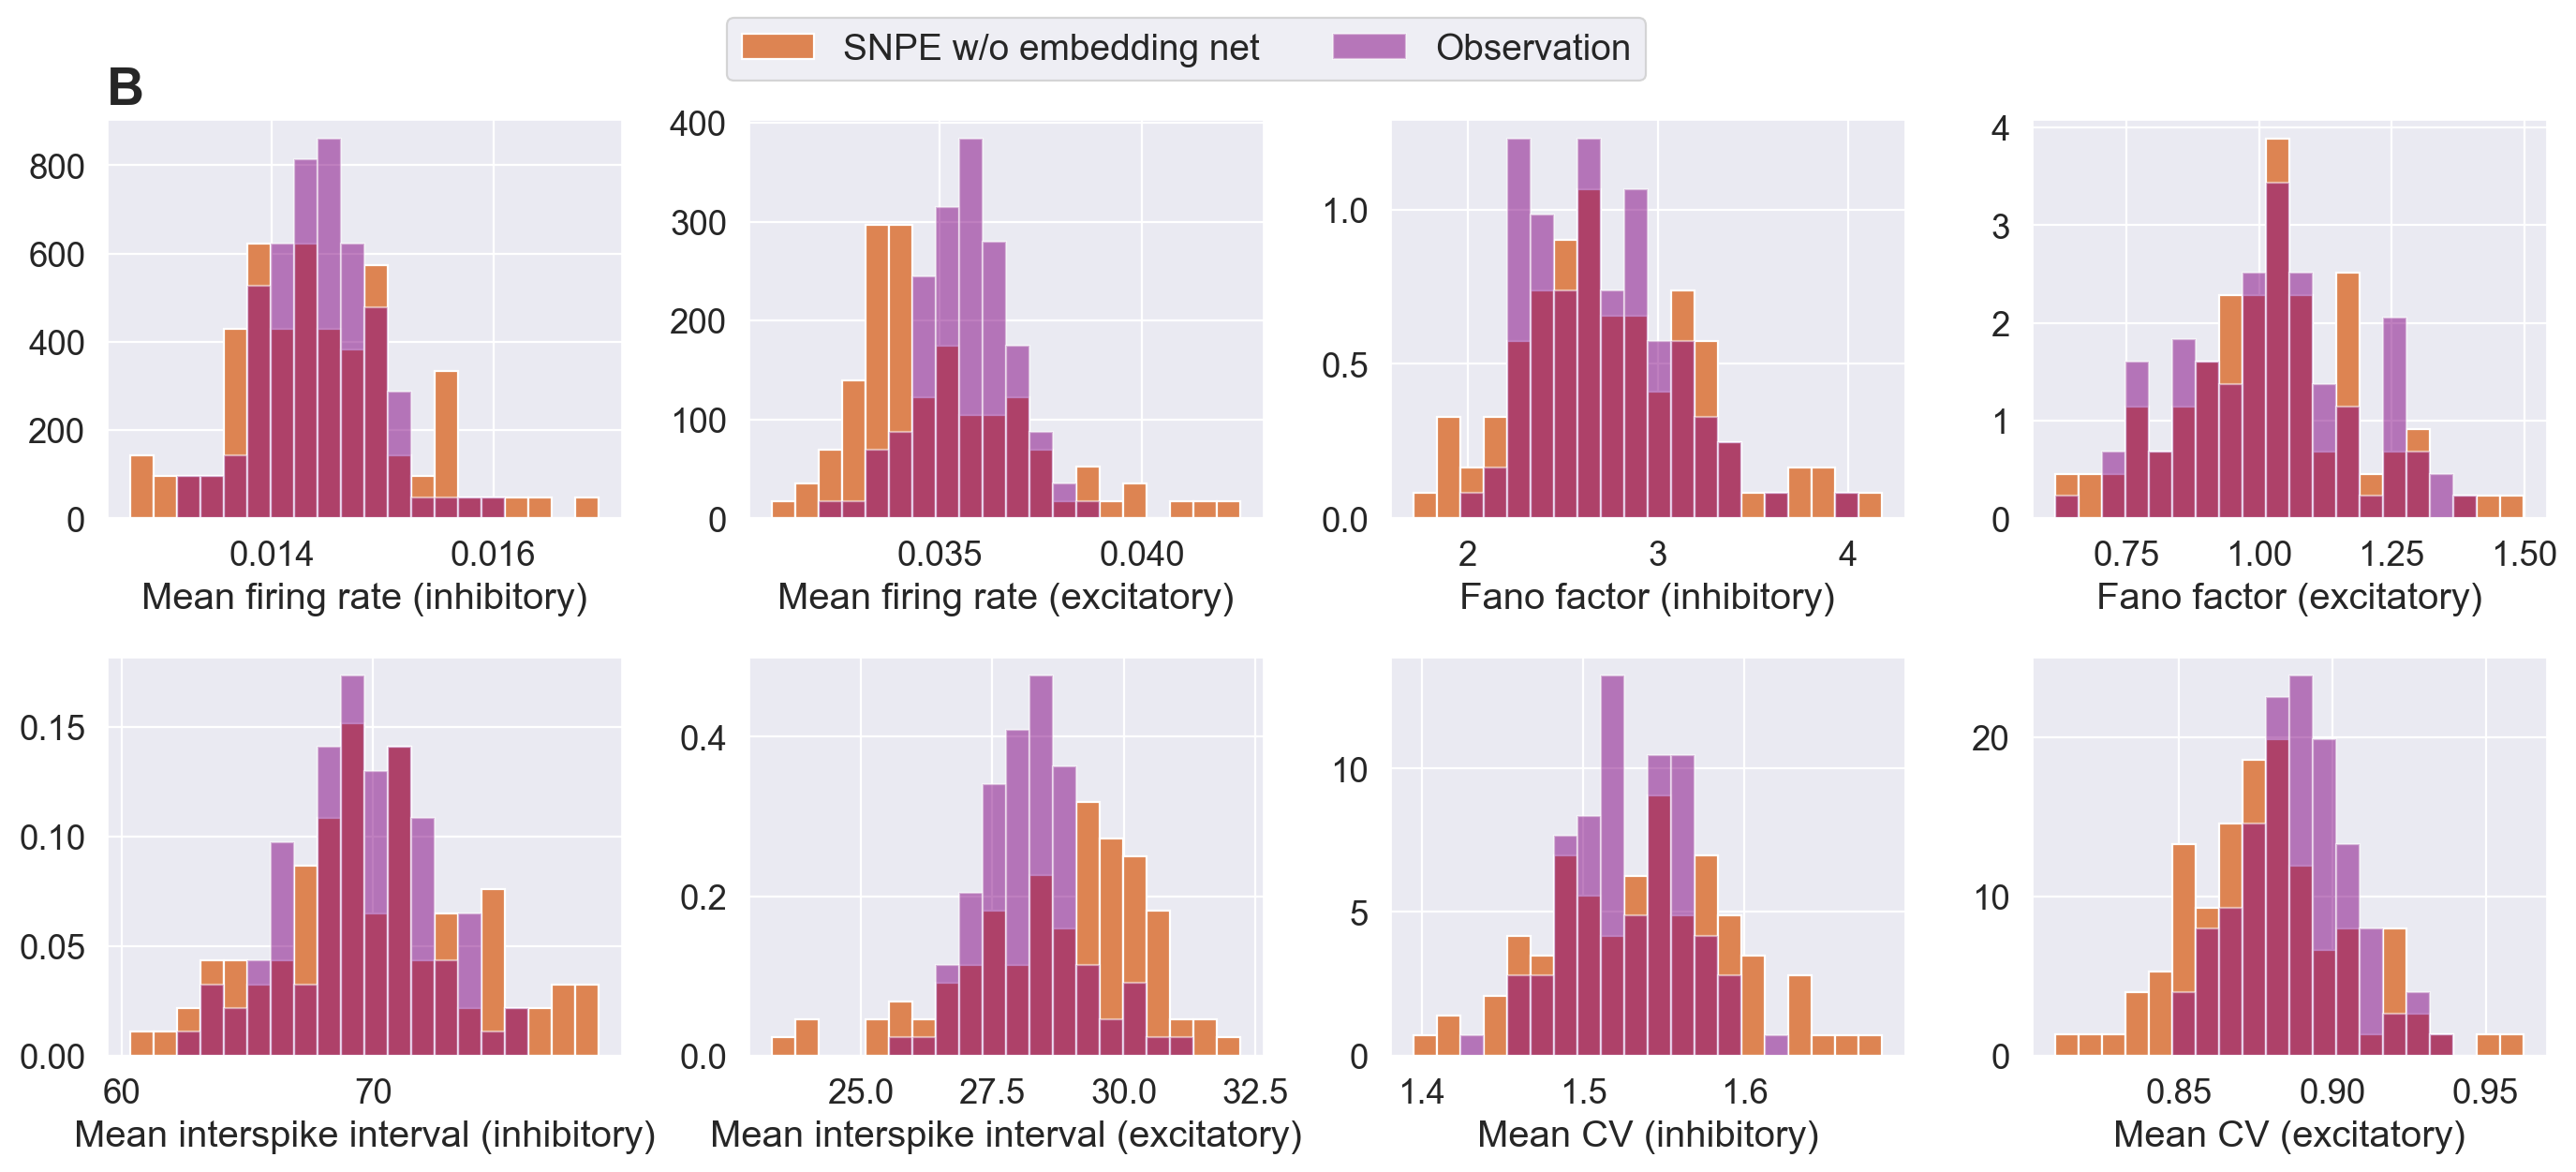

In [16]:
cols = 4
rows = 2
bins_count = 20
alpha = 0.5
label_size=14

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_obs.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        # Get bin sizes
        data_min = min(df_final_simulation_sbi_simple[sumstat_names[sumstat_idx]].min(),
                       df_obs_samples[sumstat_names[sumstat_idx]].min())
        data_max = max(df_final_simulation_sbi_simple[sumstat_names[sumstat_idx]].max(),
                       df_obs_samples[sumstat_names[sumstat_idx]].max())
        bins = np.linspace(data_min, data_max, bins_count + 1)
        
        # Sbi without embedding ent
        ax[row, col].hist(df_final_simulation_sbi_simple[sumstat_names[sumstat_idx]], 
                          label="SNPE w/o embedding net", 
                          alpha=1.0, 
                          bins=bins, 
                          color="C1", 
                          density=True)
        

        # Target distribution
        ax[row, col].hist(df_obs_samples[sumstat_names[sumstat_idx]], 
                          label="Observation", 
                          alpha=alpha, 
                          bins=bins, 
                          color="purple", 
                          density=True)
        
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]])
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1

plt.tight_layout()
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.85, 1.3), ncol=10, fontsize=label_size)
ax[0, 0].set_title("B", size=20, loc="left", fontweight="bold")

if SAVE_PLOT:
    save_path = "./for_thesis/results/sbi_simple_final_sumstats.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

#### SNPE with embedding net

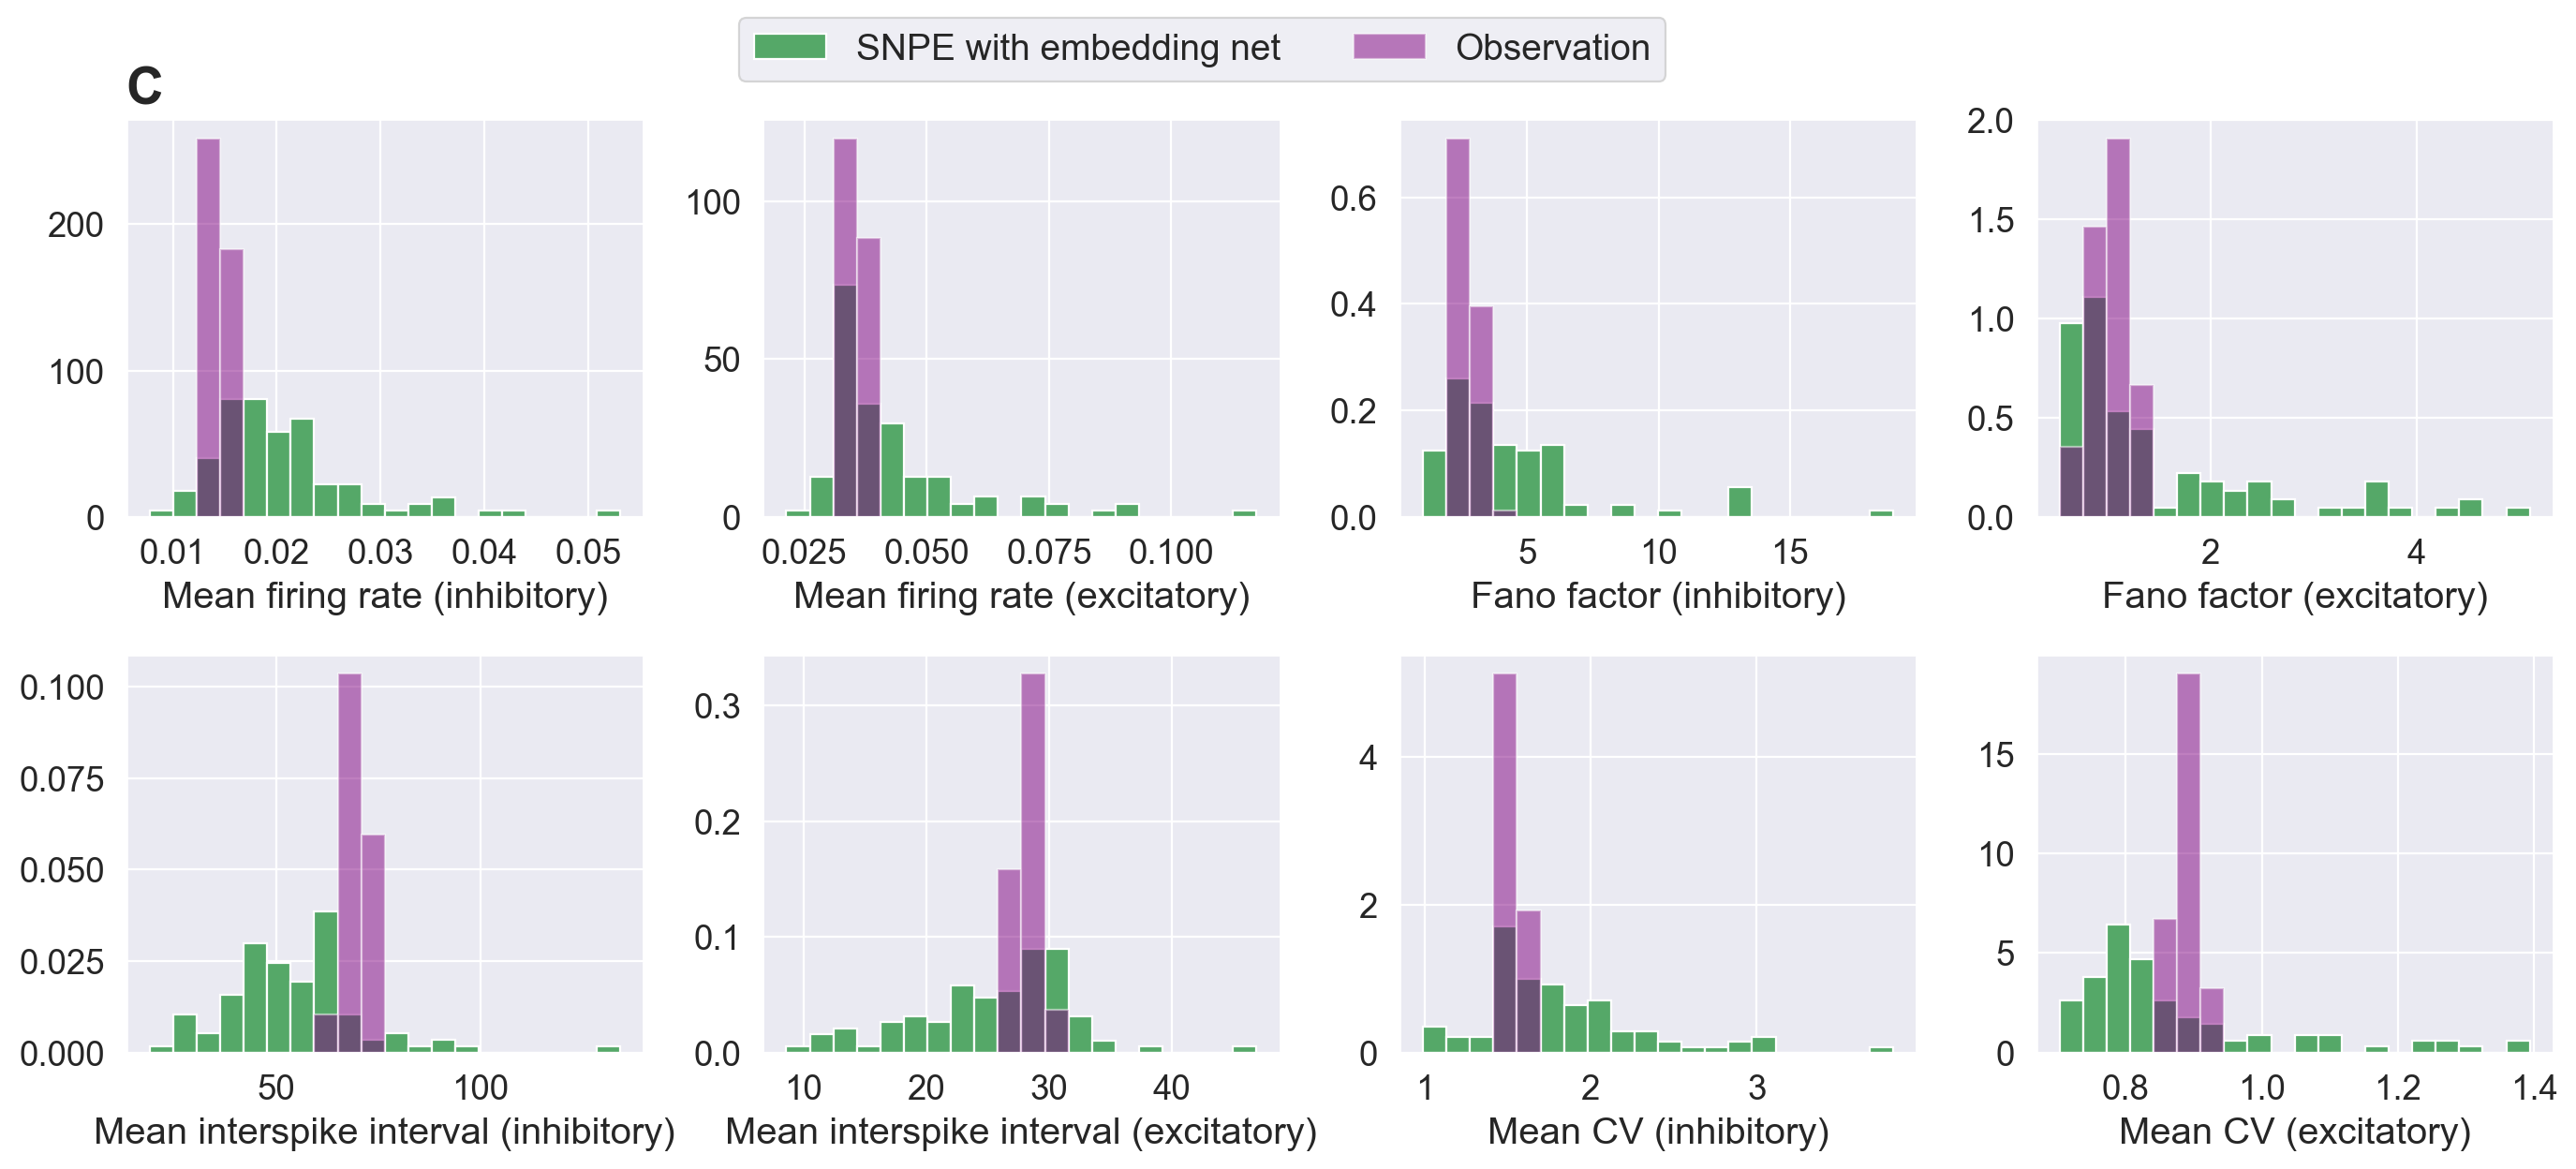

In [17]:
cols = 4
rows = 2
bins_count = 20
alpha = 0.5
label_size=14

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_obs.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        # Get bin sizes
        data_min = min(df_final_simulation_sbi_embedding[sumstat_names[sumstat_idx]].min(),
                       df_obs_samples[sumstat_names[sumstat_idx]].min())
        data_max = max(df_final_simulation_sbi_embedding[sumstat_names[sumstat_idx]].max(),
                       df_obs_samples[sumstat_names[sumstat_idx]].max())
        bins = np.linspace(data_min, data_max, bins_count + 1)
        
        # Sbi without embedding ent
        ax[row, col].hist(df_final_simulation_sbi_embedding[sumstat_names[sumstat_idx]], 
                          label="SNPE with embedding net", 
                          alpha=1.0, 
                          bins=bins, 
                          color="C2", 
                          density=True)

        # Target distribution
        ax[row, col].hist(df_obs_samples[sumstat_names[sumstat_idx]], 
                          label="Observation", 
                          alpha=alpha, 
                          bins=bins, 
                          color="purple", 
                          density=True)
        
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]])
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1

plt.tight_layout()
ax[0, 0].set_title("C", size=20, loc="left", fontweight="bold")
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.85, 1.3), ncol=10, fontsize=label_size)

if SAVE_PLOT:
    save_path = "./for_thesis/results/sbi_embedding_final_sumstats.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

##### 2d plots of density and correlation

In [18]:
combinations = {("g_ee", "g_ie"): [(0, 0), (2, 0), (4, 0)], 
                ("g_ee", "g_ei"): [(0, 1), (2, 1), (4, 1)], 
                ("g_ee", "g_ii"): [(0, 2), (2, 2), (4, 2)],
                ("g_ie", "g_ei"): [(1, 0), (3, 0), (5, 0)], 
                ("g_ie", "g_ii"): [(1, 1), (3, 1), (5, 1)],
                ("g_ei", "g_ii"): [(1, 2), (3, 2), (5, 2)]}

In [19]:
import matplotlib.ticker as ticker

In [ ]:
fig, ax = plt.subplots(6, 4, figsize=(24, 22))
sns.set(font_scale=2.)
label_size = 18


for param_pair, ax_index in combinations.items():
    # Plot 2d distribution plots
    sns.kdeplot(x=df_abc_regression_posterior_1[param_pair[0]], y=df_abc_regression_posterior_1[param_pair[1]], ax=ax[ax_index[0]], color="C0", shade=True)
    sns.kdeplot(x=df_sbi_simple_posterior_1[param_pair[0]], y=df_sbi_simple_posterior_1[param_pair[1]], ax=ax[ax_index[1]], color="C1", shade=True)
    sns.kdeplot(x=df_sbi_embedding_posterior_1[param_pair[0]], y=df_sbi_embedding_posterior_1[param_pair[1]], ax=ax[ax_index[2]], color="C2", shade=True)
    
    # Plot observed point
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=400, color="black", marker="o", ax=ax[ax_index[0]])
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=400, color="black", marker="o", ax=ax[ax_index[1]])
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=400, color="black", marker="o", ax=ax[ax_index[2]])
    
    ## Increase size of x and y labels
    # ABC
    xlabel_text_abc = ax[ax_index[0]].get_xlabel()
    ylabel_text_abc = ax[ax_index[0]].get_ylabel()
    ax[ax_index[0]].set_xlabel(xlabel_text_abc, fontsize=label_size)
    ax[ax_index[0]].set_ylabel(ylabel_text_abc, fontsize=label_size)
    
    # SBI wihtout embedding
    xlabel_text_sbi_simple = ax[ax_index[1]].get_xlabel()
    ylabel_text_sbi_simple = ax[ax_index[1]].get_ylabel()
    ax[ax_index[1]].set_xlabel(xlabel_text_sbi_simple, fontsize=label_size)
    ax[ax_index[1]].set_ylabel(ylabel_text_sbi_simple, fontsize=label_size)
    
    # SBI with embedding
    xlabel_text_sbi_embedding = ax[ax_index[2]].get_xlabel()
    ylabel_text_sbi_embedding = ax[ax_index[2]].get_ylabel()
    ax[ax_index[2]].set_xlabel(xlabel_text_sbi_embedding, fontsize=label_size)
    ax[ax_index[2]].set_ylabel(ylabel_text_sbi_embedding, fontsize=label_size)
    
    ## Set correct number of xticks
    num_xticks = 4
    num_yticks = 4
    # ABC
    ax[ax_index[0]].xaxis.set_major_locator(ticker.MaxNLocator(nbins=num_xticks)) # set the number of x-ticks to 5
    ax[ax_index[0]].yaxis.set_major_locator(ticker.MaxNLocator(nbins=num_yticks)) # set the number of x-ticks to 5
    
    # SBI without embedding
    ax[ax_index[1]].xaxis.set_major_locator(ticker.MaxNLocator(nbins=num_xticks)) # set the number of x-ticks to 5
    ax[ax_index[1]].yaxis.set_major_locator(ticker.MaxNLocator(nbins=num_yticks)) # set the number of x-ticks to 5
    
    # SBI with embedding
    ax[ax_index[2]].xaxis.set_major_locator(ticker.MaxNLocator(nbins=num_xticks)) # set the number of x-ticks to 5
    ax[ax_index[2]].yaxis.set_major_locator(ticker.MaxNLocator(nbins=num_yticks)) # set the number of x-ticks to 5
    
    
# Create correlation matrix plot
corr_matrix_abc = df_abc_regression_posterior_1.corr()
mask_abc = np.triu(np.ones_like(corr_matrix_abc, dtype=bool))

corr_matrix_sbi_simple = df_sbi_simple_posterior_1.corr()
mask_sbi_simple = np.triu(np.ones_like(corr_matrix_sbi_simple, dtype=bool))

corr_matrix_sbi_embedding = df_sbi_embedding_posterior_1.corr()
mask_sbi_embedding = np.triu(np.ones_like(corr_matrix_sbi_embedding, dtype=bool))

# Create a cmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Merge the 4th column for each respective method
gs_abc = ax[0, 3].get_gridspec()
for a in ax[:2, 3]:
    a.remove()

gs_sbi_simple = ax[3, 3].get_gridspec()
for b in ax[2:4, 3]:
    b.remove()

gs_sbi_embedding = ax[5, 3].get_gridspec()
for c in ax[4:, 3]:
    c.remove()

ax_merged_abc = fig.add_subplot(gs_abc[:2, 3])
ax_merged_sbi_simple = fig.add_subplot(gs_sbi_simple[2:4, 3])
ax_merged_sbi_embedding = fig.add_subplot(gs_sbi_embedding[4:, 3])

plt.tight_layout(pad=2., w_pad=0.2, h_pad=0.1)

# Draw the heatmap with the mask and correct
sns.heatmap(corr_matrix_abc, annot=True, mask=mask_abc, cmap=cmap, vmin=-1, vmax=1., center=0,
            square=True, linewidths=.5, cbar=True, fmt='.2f', ax=ax_merged_abc, cbar_kws={"shrink": .5, "ticks": [-1, -0.5, 0, 0.5, 1.]})

# Draw the heatmap with the mask and correct
sns.heatmap(corr_matrix_sbi_simple, annot=True, mask=mask_sbi_simple, cmap=cmap, vmin=-1, vmax=1., center=0,
            square=True, linewidths=.5, cbar=True, fmt='.2f', ax=ax_merged_sbi_simple, cbar_kws={"shrink": .5, "ticks": [-1, -0.5, 0, 0.5, 1.]})

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_sbi_embedding, annot=True, mask=mask_sbi_embedding, cmap=cmap, vmin=-1, vmax=1., center=0,
            square=True, linewidths=.5, cbar=True, fmt='.2f', ax=ax_merged_sbi_embedding, cbar_kws={"shrink": .5, "ticks": [-1, -0.5, 0, 0.5, 1.]})


# Set title references for table description
title_size = 20
ax[0, 0].set_title("A1", size=title_size, fontweight="bold", loc="left")
ax_merged_abc.set_title("A2", size=title_size, fontweight="bold", loc="left")
ax[2, 0].set_title("B1", size=title_size, fontweight="bold", loc="left")
ax_merged_sbi_simple.set_title("B2", size=title_size, fontweight="bold", loc="left")
ax[4, 0].set_title("C1", size=title_size, fontweight="bold", loc="left")
ax_merged_sbi_embedding.set_title("C2", size=title_size, fontweight="bold", loc="left")

if SAVE_PLOT:
    save_path = "./for_thesis/results/2d_plots_params.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

# Reset back to normal, in case I forget
sns.reset_orig()
sns.set(context="paper", font_scale=1.5, style='darkgrid')

#### Power spectral density

In [ ]:
# Observed psd
freq_obs, pds_obs = signal.welch(obs_hist)

# ABC regression (with fix)
hist_abc_reg = helper_funcs.load_file("../2pop/data/sim_2/abc_regression/2pop_simulations_histogram_2")
hist_abc_reg_final = np.delete(hist_abc_reg, drop_index_abc, axis=0)

# SBI without embedding (simple)
hist_sbi_simple_final = helper_funcs.load_file("../2pop/data/sim_2/sbi_simple/2pop_simulations_histogram_2")

# SBI embedding
hist_sbi_embedding_final = helper_funcs.load_file("../2pop/data/sim_2/sbi_embedding/2pop_simulations_histogram_2")

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12), dpi=150, sharex="col")

std_1_line_color = "red"
std_2_line_color = "black"
std_3_line_color = "magenta"
alpha=0.8

# Custom palette to slightly differ colors of inh and exc
custom_palette = [
    (0.1, 0.5, 0.8),  # similar to C0
    (0.9, 0.4, 0.15),  # similar to C1
    (0.2, 0.65, 0.25),  # similar to C2
]

# Prepare data for mean and standard deviation calculations
inh_data_abc = []
exc_data_abc = []
inh_data_sbi_simple = []
exc_data_sbi_simple = []
inh_data_sbi_embedding = []
exc_data_sbi_embedding = []

# Plot the observed samples
for i in range(len(hist_abc_reg_final)):
    ## ABC
    freq_abc_reg, psd_abc_reg = signal.welch(hist_abc_reg_final[i])
    # Inhibitory
    ax[0, 0].plot(freq_abc_reg, psd_abc_reg[1], color="C0")
    inh_data_abc.append(psd_abc_reg[1])

    # Excitatory
    ax[0, 1].plot(freq_abc_reg, psd_abc_reg[0], color="C0")
    exc_data_abc.append(psd_abc_reg[0])
    
    
    ## SBI without embedding
    freq_sbi_simple, psd_sbi_simple = signal.welch(hist_sbi_simple_final[i])
    # Inhibitory
    ax[1, 0].plot(freq_sbi_simple, psd_sbi_simple[1], color="C1")
    inh_data_sbi_simple.append(psd_sbi_simple[1])
    
    # Excitatory
    ax[1, 1].plot(freq_sbi_simple, psd_sbi_simple[0], color="C1")
    exc_data_sbi_simple.append(psd_sbi_simple[0])
    
    
    ## SBI with embedding
    freq_sbi_embedding, psd_sbi_embedding = signal.welch(hist_sbi_embedding_final[i])
    # Inhibitory
    ax[2, 0].plot(freq_sbi_embedding, psd_sbi_embedding[1], color="C2")
    inh_data_sbi_embedding.append(psd_sbi_embedding[1])
    
    # Excitatory
    ax[2, 1].plot(freq_sbi_embedding, psd_sbi_embedding[0], color="C2")
    exc_data_sbi_embedding.append(psd_sbi_embedding[0])

## Calculate mean and standard deviation
# ABC
# Calculate mean and standard deviation
inh_data_abc = np.log(np.array(inh_data_abc))
exc_data_abc = np.log(np.array(exc_data_abc))

inh_mean_abc = np.mean(inh_data_abc, axis=0)
exc_mean_abc = np.mean(exc_data_abc, axis=0)

inh_std_abc = np.std(inh_data_abc, axis=0)
exc_std_abc = np.std(exc_data_abc, axis=0)

# SBI without embedding
inh_data_sbi_simple = np.log(np.array(inh_data_sbi_simple))
exc_data_sbi_simple = np.log(np.array(exc_data_sbi_simple))

inh_mean_sbi_simple = np.mean(inh_data_sbi_simple, axis=0)
exc_mean_sbi_simple = np.mean(exc_data_sbi_simple, axis=0)

inh_std_sbi_simple = np.std(inh_data_sbi_simple, axis=0)
exc_std_sbi_simple = np.std(exc_data_sbi_simple, axis=0)

# SBI with embedding
inh_data_sbi_embedding = np.log(np.array(inh_data_sbi_embedding))
exc_data_sbi_embedding = np.log(np.array(exc_data_sbi_embedding))

inh_mean_sbi_embedding = np.mean(np.array(inh_data_sbi_embedding), axis=0)
exc_mean_sbi_embedding = np.mean(np.array(exc_data_sbi_embedding), axis=0)

inh_std_sbi_embedding = np.std(np.array(inh_data_sbi_embedding), axis=0)
exc_std_sbi_embedding = np.std(np.array(exc_data_sbi_embedding), axis=0)

# Plot observation line
observation_color = "yellow"
zorder_obs = 2
ax[0, 0].plot(freq_obs, pds_obs[1], color=observation_color, lw=2.4, zorder=zorder_obs, label="Observation")
ax[0, 1].plot(freq_obs, pds_obs[0], color=observation_color, lw=2.4, zorder=zorder_obs)
ax[1, 0].plot(freq_obs, pds_obs[1], color=observation_color, lw=2.4, zorder=zorder_obs)
ax[1, 1].plot(freq_obs, pds_obs[0], color=observation_color, lw=2.4, zorder=zorder_obs)
ax[2, 0].plot(freq_obs, pds_obs[1], color=observation_color, lw=2.4, zorder=zorder_obs)
ax[2, 1].plot(freq_obs, pds_obs[0], color=observation_color, lw=2.4, zorder=zorder_obs)


## Plot std lines
zorder_std = 3
# ABC
# ax[0, 0].fill_between(freq_abc_reg, y1=np.exp(inh_mean_abc + (1 * inh_std_abc)), y2=np.exp(inh_mean_abc - (1 * inh_std_abc)), linestyle="-", color="purple", alpha=0.4, lw=2, zorder=2)
# ax[0, 1].fill_between(freq_abc_reg, y1=np.exp(exc_mean_abc + (1 * exc_std_abc)), y2=np.exp(exc_mean_abc - (1 * exc_std_abc)), linestyle="-", color="purple", alpha=0.4, lw=2, zorder=2)
ax[0, 0].plot(freq_abc_reg, np.exp(inh_mean_abc + (1*inh_std_abc)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std, label="1 SD") # Upper line of 1 std
ax[0, 0].plot(freq_abc_reg, np.exp(inh_mean_abc - (1*inh_std_abc)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 1 std
ax[0, 0].plot(freq_abc_reg, np.exp(inh_mean_abc + (2*inh_std_abc)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std, label="2 SD") # Upper line of 2 std
ax[0, 0].plot(freq_abc_reg, np.exp(inh_mean_abc - (2*inh_std_abc)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 2 std
ax[0, 0].plot(freq_abc_reg, np.exp(inh_mean_abc + (3*inh_std_abc)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std, label="3 SD") # Upper line of 3 std
ax[0, 0].plot(freq_abc_reg, np.exp(inh_mean_abc - (3*inh_std_abc)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 3 std

ax[0, 1].plot(freq_abc_reg, np.exp(exc_mean_abc + (1*exc_std_abc)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 1 std
ax[0, 1].plot(freq_abc_reg, np.exp(exc_mean_abc - (1*exc_std_abc)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 1 std
ax[0, 1].plot(freq_abc_reg, np.exp(exc_mean_abc + (2*exc_std_abc)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 2 std
ax[0, 1].plot(freq_abc_reg, np.exp(exc_mean_abc - (2*exc_std_abc)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 2 std
ax[0, 1].plot(freq_abc_reg, np.exp(exc_mean_abc + (3*exc_std_abc)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 3 std
ax[0, 1].plot(freq_abc_reg, np.exp(exc_mean_abc - (3*exc_std_abc)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 3 std


# SBI without embedding
ax[1, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_simple + (1*inh_std_sbi_simple)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 1 std
ax[1, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_simple - (1*inh_std_sbi_simple)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 1 std
ax[1, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_simple + (2*inh_std_sbi_simple)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 2 std
ax[1, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_simple - (2*inh_std_sbi_simple)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 2 std
ax[1, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_simple + (3*inh_std_sbi_simple)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 3 std
ax[1, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_simple - (3*inh_std_sbi_simple)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 3 std

ax[1, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_simple + (1*exc_std_sbi_simple)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 1 std
ax[1, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_simple - (1*exc_std_sbi_simple)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 1 std
ax[1, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_simple + (2*exc_std_sbi_simple)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 2 std
ax[1, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_simple - (2*exc_std_sbi_simple)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 2 std
ax[1, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_simple + (3*exc_std_sbi_simple)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 3 std
ax[1, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_simple - (3*exc_std_sbi_simple)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 3 std

# SBI with embedding
ax[2, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_embedding + (1*inh_std_sbi_embedding)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 1 std
ax[2, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_embedding - (1*inh_std_sbi_embedding)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 1 std
ax[2, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_embedding + (2*inh_std_sbi_embedding)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 2 std
ax[2, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_embedding - (2*inh_std_sbi_embedding)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 2 std
ax[2, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_embedding + (3*inh_std_sbi_embedding)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 3 std
ax[2, 0].plot(freq_abc_reg, np.exp(inh_mean_sbi_embedding - (3*inh_std_sbi_embedding)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 3 std

ax[2, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_embedding + (1*exc_std_sbi_embedding)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 1 std
ax[2, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_embedding - (1*exc_std_sbi_embedding)), linestyle="--", color=std_1_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 1 std
ax[2, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_embedding + (2*exc_std_sbi_embedding)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 2 std
ax[2, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_embedding - (2*exc_std_sbi_embedding)), linestyle="--", color=std_2_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 2 std
ax[2, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_embedding + (3*exc_std_sbi_embedding)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Upper line of 3 std
ax[2, 1].plot(freq_abc_reg, np.exp(exc_mean_sbi_embedding - (3*exc_std_sbi_embedding)), linestyle="--", color=std_3_line_color, alpha=alpha, lw=1.4, zorder=zorder_std) # Lower line of 3 std


# Ax specifics
ax[0, 0].set_yscale("log")
ax[0, 1].set_yscale("log")
ax[1, 0].set_yscale("log")
ax[1, 1].set_yscale("log")
ax[2, 0].set_yscale("log")
ax[2, 1].set_yscale("log")

ax[0, 0].set_title("Inhibitory", size=22)
ax[0, 1].set_title("Excitatory", size=22)

# Set title for table reference
ax[0, 0].set_title("A1", loc="left", fontweight="bold")
ax[0, 1].set_title("A2", loc="left", fontweight="bold")

ax[1, 0].set_title("B1", loc="left", fontweight="bold")
ax[1, 1].set_title("B2", loc="left", fontweight="bold")

ax[2, 0].set_title("C1", loc="left", fontweight="bold")
ax[2, 1].set_title("C2", loc="left", fontweight="bold")

# Set xlabel
ax[2, 0].set_xlabel("Frequency")
ax[2, 1].set_xlabel("Frequency")

# Set legend
ax[0, 0].legend(loc="upper center", bbox_to_anchor=(1., 1.35), ncol=4, fontsize=14)

#plt.tight_layout()
if SAVE_PLOT:
    save_path = "./for_thesis/results/psd_plot_all.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

In [ ]:
df_obs_samples[summary_stat_names].corr()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
data1 = np.random.normal(0, 1, size=(1000, 2))
data2 = np.random.normal(3, 1, size=(1000, 2))

# Create a 2D scatter plot
plt.scatter(data1[:, 0], data1[:, 1], label='Distribution 1', alpha=0.5)
plt.scatter(data2[:, 0], data2[:, 1], label='Distribution 2', alpha=0.5)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
data1 = np.random.normal(0, 1, size=(1000, 2))
data2 = np.random.normal(3, 1, size=(1000, 2))

# Combine the data
data = np.vstack([data1, data2])

# Create a 2D histogram
plt.hist2d(data[:, 0], data[:, 1], bins=30, cmap='viridis')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Frequency')
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(42)
data1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=200)
data2 = np.random.multivariate_normal([3, 3], [[1, -0.5], [-0.5, 1]], size=200)

# Create 2D density plots
fig, ax = plt.subplots()

sns.kdeplot(data1[:, 0], data1[:, 1], ax=ax, cmap='Blues', shade=True, shade_lowest=False, label='Data 1')
sns.kdeplot(data2[:, 0], data2[:, 1], ax=ax, cmap='Reds', shade=True, shade_lowest=False, label='Data 2')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(16, 14), sharex="row", dpi=160)
fig.subplots_adjust(wspace=-1.2, hspace=0.5)
alpha_value_posteriors = 0.5
bbox=("upper left", (0., 1.))
ylabel = None
label_size = 14

for row in range(4):
    
    # abc_regression_posterior_distribution_0 = stats.gaussian_kde(df_abc_regression_posterior_0[param_names[row]])
    # sbi_simple_posterior_distribution_0 = stats.gaussian_kde(df_sbi_simple_posterior_0[param_names[row]])
    # sbi_embedding_posterior_distribution_0 = stats.gaussian_kde(df_sbi_embedding_posterior_0[row])
    # todo: could do posterior_distribution.resample(#number) - would this be correct?

    # True theta value
    theta_true = float(df_obs[param_names[row]])
    
    ## Ax column 1
    # Prior
    plot_prior(min_val=min_max_dict[param_names[row][-1]]["min_value"], 
               max_val=min_max_dict[param_names[row][-1]]["max_value"],
               x_label=param_names[row], 
               obs_value=float(df_obs[param_names[row]]), 
               ax=ax[row, 0], 
               solid_line=False, 
               color="black", 
               fontsize=label_size, 
               set_legend=False)
    
    
    ## Ax column 2
    # Posteriors ABC with regression adjustment from simulation 0
    sns.kdeplot(data=df_abc_regression_posterior_0, 
                x=param_names[row], 
                ax=ax[row, 1], 
                fill=True, 
                alpha=alpha_value_posteriors, label="ABC w/ reg. adj.")
    
    # Posteriors SNPE without embedding net (simple) from simulation 0
    sns.kdeplot(data=df_sbi_simple_posterior_0, 
                x=param_names[row], 
                ax=ax[row, 1], 
                fill=True, 
                alpha=alpha_value_posteriors, 
                label="SNPE w/o embedding net")
    
    # Posteriors SNPE with embedding net from simulation 0
    sns.kdeplot(data=df_sbi_embedding_posterior_0, 
                x=param_names[row], 
                ax=ax[row, 1], 
                fill=True, 
                alpha=alpha_value_posteriors, 
                label="SNPE w/ embedding net")
    
    # Ax specifics
    ymin, ymax = ax[row, 1].get_ylim()
    # ax[row, 1].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
    #                   label=rf"$\theta_{{true}}$: {theta_true:.3}", alpha=0.6, ls="--")
    ax[row, 1].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
                      label=rf"$\theta_{{true}}$", alpha=0.6, ls="--")
    #ax[row, 1].legend(loc=bbox[0], fontsize=label_size)
    ax[row, 1].set_ylabel(ylabel)
    
    
    ## Ax column 3
    # Posterior ABC from simulation 1
    sns.kdeplot(data=df_abc_regression_posterior_1, 
                x=param_names[row], 
                ax=ax[row, 2], 
                fill=True, 
                alpha=alpha_value_posteriors, 
                label="ABC w/ reg. adj.")
    
    # Posterior SBI novel from simulation 0
    sns.kdeplot(data=df_sbi_simple_posterior_1, 
                x=param_names[row], 
                ax=ax[row, 2], fill=True, 
                alpha=alpha_value_posteriors, 
                label="SBI w/o embedding net")
    
    # Posterior SBI embedding from simulation 1
    sns.kdeplot(data=df_sbi_embedding_posterior_1, 
                x=param_names[row], 
                ax=ax[row, 2], fill=True, 
                alpha=alpha_value_posteriors, 
                label="SBI w/ embedding net")
    
    # Ax specifics
    ymin, ymax = ax[row, 2].get_ylim()
    # ax[row, 2].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
    #                   label=rf"$\theta_{{true}}$: {theta_true:.3}", alpha=0.6, ls="--")
    ax[row, 2].vlines(x=theta_true, ymin=ymin, ymax=ymax, color="black", 
                      label=rf"$\theta_{{true}}$", alpha=0.6, ls="--")
    #ax[row, 2].legend(loc=bbox[0], fontsize=label_size)
    ax[row, 2].set_ylabel(ylabel)

plt.tight_layout()
# Titles
ax[0, 0].set_title("Prior", size=18)
ax[0, 1].set_title("Posterior 1", size=18)
ax[0, 2].set_title("Posterior 2", size=18)
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.35), ncol=4, fontsize=label_size)

#fig.subplots_adjust(bottom=-0.15)

# if SAVE_PLOT:
#     save_path = "./for_thesis/results/posterior_distributions.pdf"
#     print(f"Saving to file: {save_path}")
#     plt.savefig(save_path, format="pdf", bbox_inches="tight")

In [ ]:
# Posteriors from simulation 0 (initial with uniform priors)
df_abc_regression_posterior_0 = helper_funcs.load_file("../2pop/abc/abc_data/sim_0/regression/2pop_df_abc_regression_params_0")
df_sbi_simple_posterior_0 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/simple/2pop_df_sbi_simple_params_0")
df_sbi_embedding_posterior_0 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/embedding/2pop_df_sbi_embedding_params_0")

In [ ]:
# Posteriors from simulation 1 (with posteriors from simulation 0 as priors)
df_abc_regression_posterior_1 = helper_funcs.load_file("../2pop/abc/abc_data/sim_1/regression/2pop_df_abc_regression_params_1")
df_sbi_simple_posterior_1 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/simple/2pop_df_sbi_simple_params_1")
df_sbi_embedding_posterior_1 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/embedding/2pop_df_sbi_embedding_params_1")

In [ ]:
df_abc_regression_posterior_0["g_ee"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a sample dataframe
# Replace this with your own dataframe df_abc_regression_posterior_1
data = {
    "g_ee": df_abc_regression_posterior_0["g_ee"],
    "g_ei": df_abc_regression_posterior_0["g_ei"],
    "g_ie": df_abc_regression_posterior_0["g_ie"],
    "g_ii": df_abc_regression_posterior_0["g_ii"],
}

df = pd.DataFrame(data)

fig = plt.figure(figsize=(10, 8))


In [ ]:
plt.scatter()

In [ ]:
df = pd.DataFrame(data)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Normalize the fourth dimension to be between 0 and 1
normalized_param4 = (df["g_ii"] - df["g_ii"].min()) / (df["g_ii"].max() - df["g_ii"].min())

ax.scatter(df_obs["g_ee"], df_obs["g_ei"], df_obs["g_ie"], marker="*", s=800, color="black")

scatter = ax.scatter(
    df["g_ee"], df["g_ei"], df["g_ie"], c=normalized_param4, cmap="viridis"
)

ax.set_xlabel("g_ee")
ax.set_ylabel("g_ei")
ax.set_zlabel("g_ie")


# Add a colorbar to represent the fourth dimension
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel("g_ii")

plt.show()

In [ ]:
combinations = {("g_ee", "g_ie"): (0, 0), 
                ("g_ee", "g_ei"): (0, 1), 
                ("g_ee", "g_ii"): (0, 2),
                ("g_ie", "g_ei"): (1, 0), 
                ("g_ie", "g_ii"): (1, 1),
                ("g_ei", "g_ii"): (1, 2)}

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Create 2D density plots
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for param_pair, ax_index in combinations.items():
    # Plot 2d distribution plots
    sns.kdeplot(x=df_abc_regression_posterior_0[param_pair[0]], y=df_abc_regression_posterior_0[param_pair[1]], ax=ax[ax_index], cmap="Blues", shade=True, alpha=0.3, zorder=1)
    sns.kdeplot(x=df_abc_regression_posterior_1[param_pair[0]], y=df_abc_regression_posterior_1[param_pair[1]], ax=ax[ax_index], cmap="Reds", shade=True, alpha=1., zorder=1)
    
    # Plot observed point
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=600, color="black", marker="*", ax=ax[ax_index], zorder=3)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for param_pair, ax_index in combinations.items():
    # Plot 2d distribution plots
    sns.kdeplot(x=df_abc_regression_posterior_1[param_pair[0]], y=df_abc_regression_posterior_1[param_pair[1]], ax=ax[ax_index], cmap="Reds", shade=True, alpha=1., zorder=1)
    sns.kdeplot(x=df_abc_regression_posterior_0[param_pair[0]], y=df_abc_regression_posterior_0[param_pair[1]], ax=ax[ax_index], cmap="Blues", shade=True, alpha=0.3, zorder=2)
    
    # Plot observed point
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=600, color="black", marker="*", ax=ax[ax_index], zorder=3)


In [ ]:
combinations

In [ ]:
combinations = {("g_ee", "g_ie"): [(0, 0), (2, 0), (4, 0)], 
                ("g_ee", "g_ei"): [(0, 1), (2, 1), (4, 1)], 
                ("g_ee", "g_ii"): [(0, 2), (2, 2), (4, 2)],
                ("g_ie", "g_ei"): [(1, 0), (3, 0), (5, 0)], 
                ("g_ie", "g_ii"): [(1, 1), (3, 1), (5, 1)],
                ("g_ei", "g_ii"): [(1, 2), (3, 2), (5, 2)]}

In [ ]:
fig, ax = plt.subplots(6, 4, figsize=(22, 22), )
sns.set(font_scale=2.)


for param_pair, ax_index in combinations.items():
    # Plot 2d distribution plots
    sns.kdeplot(x=df_abc_regression_posterior_1[param_pair[0]], y=df_sbi_simple_posterior_1[param_pair[1]], ax=ax[ax_index[0]], color="C0", shade=True)
    sns.kdeplot(x=df_sbi_simple_posterior_1[param_pair[0]], y=df_sbi_simple_posterior_1[param_pair[1]], ax=ax[ax_index[1]], color="C1", shade=True)
    sns.kdeplot(x=df_sbi_embedding_posterior_1[param_pair[0]], y=df_sbi_embedding_posterior_1[param_pair[1]], ax=ax[ax_index[2]], color="C2", shade=True)
    
    # Plot observed point
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=400, color="black", marker="*", ax=ax[ax_index[0]])
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=400, color="black", marker="*", ax=ax[ax_index[1]])
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=400, color="black", marker="*", ax=ax[ax_index[2]])
    
    
# Create correlation matrix plot
corr_matrix_abc = df_abc_regression_posterior_1.corr()
mask_abc = np.triu(np.ones_like(corr_matrix_abc, dtype=bool))

corr_matrix_sbi_simple = df_sbi_simple_posterior_1.corr()
mask_sbi_simple = np.triu(np.ones_like(corr_matrix_sbi_simple, dtype=bool))

corr_matrix_sbi_embedding = df_sbi_embedding_posterior_1.corr()
mask_sbi_embedding = np.triu(np.ones_like(corr_matrix_sbi_embedding, dtype=bool))

# Create a cmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Merge the 4th column for each respective method
gs_abc = ax[0, 3].get_gridspec()
for a in ax[:2, 3]:
    a.remove()

gs_sbi_simple = ax[3, 3].get_gridspec()
for b in ax[2:4, 3]:
    b.remove()

gs_sbi_embedding = ax[5, 3].get_gridspec()
for c in ax[4:, 3]:
    c.remove()

ax_merged_abc = fig.add_subplot(gs_abc[:2, 3])
ax_merged_sbi_simple = fig.add_subplot(gs_sbi_simple[2:4, 3])
ax_merged_sbi_embedding = fig.add_subplot(gs_sbi_embedding[4:, 3])

# Draw the heatmap with the mask and correct
sns.heatmap(corr_matrix_abc, annot=True, mask=mask_abc, cmap=cmap, vmin=-1, vmax=.5, center=0,
            square=True, linewidths=.5, cbar=True, fmt='.2f', ax=ax_merged_abc, cbar_kws={"shrink": .5, "ticks": [-1, -0.5, 0, 0.5]})

# Draw the heatmap with the mask and correct
sns.heatmap(corr_matrix_sbi_simple, annot=True, mask=mask, cmap=cmap, vmin=-1, vmax=.5, center=0,
            square=True, linewidths=.5, cbar=True, fmt='.2f', ax=ax_merged_sbi_simple, cbar_kws={"shrink": .5, "ticks": [-1, -0.5, 0, 0.5]})

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_sbi_embedding, annot=True, mask=mask, cmap=cmap, vmin=-1, vmax=.5, center=0,
            square=True, linewidths=.5, cbar=True, fmt='.2f', ax=ax_merged_sbi_embedding, cbar_kws={"shrink": .5, "ticks": [-1, -0.5, 0, 0.5]})

# Set x and y label size
#ax[0, 0].set_xlabel(fontsize=25)
#ax[0, 0].tick_params(axis="y", labelsize=25)

plt.tight_layout(pad=2., w_pad=0.2, h_pad=0.1)

# if SAVE_PLOT:
#     save_path = "./for_thesis/results/2d_plots_params.pdf"
#     print(f"Saving to file: {save_path}")
#     plt.savefig(save_path, format="pdf", bbox_inches="tight")
    
sns.reset_orig()
sns.set(context="paper", font_scale=1.5, style='darkgrid')

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for param_pair, ax_index in combinations.items():
    # Plot 2d distribution plots
    sns.kdeplot(x=df_sbi_embedding_posterior_1[param_pair[0]], y=df_sbi_embedding_posterior_1[param_pair[1]], ax=ax[ax_index], cmap="Greens", shade=True)
    
    # Plot observed point
    sns.scatterplot(x=df_obs[param_pair[0]], y=df_obs[param_pair[1]], s=600, color="black", marker="*", ax=ax[ax_index])

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a subplot grid
fig, ax = plt.subplots(2, 4, figsize=(24, 8))

# Create 2D density plots
sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax[0, 0], cmap='Blues', shade=True, thresh=0.05)
sns.scatterplot(x=df_obs["g_ee"], y=df_obs["g_ie"], ax=ax[0, 0], marker="*", s=800, color="red")

sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ei"], ax=ax[0, 1], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ii"], ax=ax[0, 2], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ei"], y=df_abc_regression_posterior_0["g_ie"], ax=ax[1, 0], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ei"], y=df_abc_regression_posterior_0["g_ii"], ax=ax[1, 1], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ie"], y=df_abc_regression_posterior_0["g_ii"], ax=ax[1, 2], cmap='Blues', shade=True, thresh=0.05)

# Create correlation matrix plot
corr_matrix_abc = df_abc_regression_posterior_0.corr()
mask = np.triu(np.ones_like(corr_matrix_abc, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Merge the 4th column subplots
gs = ax[0, 3].get_gridspec()
for a in ax[:, 3]:
    a.remove()

ax_merged = fig.add_subplot(gs[:, 3])

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_abc, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar=False, fmt='.2f', ax=ax_merged)

plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Create 2D density plots
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

#sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax, cmap='Blues', shade=True, thresh=0.05, label='Data 1')
sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax[0, 0], cmap='Blues', shade=True, thresh=0.05)# ax=ax[0])
sns.scatterplot(x=df_obs["g_ee"], y=df_obs["g_ie"], ax=ax[0,0], marker="*", s=800, color="red")

sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ei"], ax=ax[0, 1], cmap='Blues', shade=True, thresh=0.05)
sns.scatterplot(x=df_obs["g_ee"], y=df_obs["g_ie"], ax=ax[0,0], marker="*", s=800, color="red")

sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ii"], ax=ax[0, 2], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ei"], y=df_abc_regression_posterior_0["g_ie"], ax=ax[1, 0], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ei"], y=df_abc_regression_posterior_0["g_ii"], ax=ax[1, 1], cmap='Blues', shade=True, thresh=0.05)
sns.kdeplot(x=df_abc_regression_posterior_0["g_ie"], y=df_abc_regression_posterior_0["g_ii"], ax=ax[1, 2], cmap='Blues', shade=True, thresh=0.05)

# ax.set_xlabel('g_ii')
# ax.set_ylabel('g_ei')
# ax.legend()
# plt.show()


In [ ]:
corr_matrix_abc = df_abc_regression_posterior_0.corr()

mask = np.triu(np.ones_like(corr_matrix_abc))

sns.heatmap(corr_matrix_abc, annot=True, mask=mask)

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr_matrix_abc = df_abc_regression_posterior_0.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix_abc, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Customize the colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_abc, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1}, fmt='.2f')

plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [ ]:
sns.heatmap(df_abc_regression_posterior_0.corr(), annot=True)

In [ ]:
# Create 2D density plots
fig, ax = plt.subplots()

#sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax, cmap='Blues', shade=True, thresh=0.05, label='Data 1')
sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ei"], ax=ax, cmap='Reds', shade=True, thresh=0.05, label='Data 2')

In [ ]:
# Create 2D density plots
fig, ax = plt.subplots()

#sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax, cmap='Blues', shade=True, thresh=0.05, label='Data 1')
sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ii"], ax=ax, cmap='Reds', shade=True, thresh=0.05, label='Data 2')

In [ ]:
# Create 2D density plots
fig, ax = plt.subplots()

#sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax, cmap='Blues', shade=True, thresh=0.05, label='Data 1')
sns.kdeplot(x=df_abc_regression_posterior_0["g_ie"], y=df_abc_regression_posterior_0["g_ei"], ax=ax, cmap='Reds', shade=True, thresh=0.05, label='Data 2')

In [ ]:
# Create 2D density plots
fig, ax = plt.subplots()

#sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax, cmap='Blues', shade=True, thresh=0.05, label='Data 1')
sns.kdeplot(x=df_abc_regression_posterior_0["g_ie"], y=df_abc_regression_posterior_0["g_ii"], ax=ax, cmap='Reds', shade=True, thresh=0.05, label='Data 2')

In [ ]:
# Create 2D density plots
fig, ax = plt.subplots()

#sns.kdeplot(x=df_abc_regression_posterior_0["g_ee"], y=df_abc_regression_posterior_0["g_ie"], ax=ax, cmap='Blues', shade=True, thresh=0.05, label='Data 1')
sns.kdeplot(x=df_abc_regression_posterior_0["g_ei"], y=df_abc_regression_posterior_0["g_ii"], ax=ax, cmap='Reds', shade=True, thresh=0.05, label='Data 2')

In [ ]:
helper_funcs.load_file("../2pop/data/sim_1/sbi_embedding/2pop_simulations_1")["g_ee"].max()

In [ ]:
freq_obs, psd_obs = signal.welch(obs_hist)

In [ ]:
hist_sbi_embedding_final = helper_funcs.load_file("../2pop/data/sim_2/sbi_embedding/2pop_simulations_histogram_2")
hist_sbi_embedding_final_masked = np.delete(hist_sbi_embedding_final, drop_index_embedding, axis=0)

In [ ]:
for i in range(len(hist_sbi_embedding_final_masked)):
    freq_sbi_embedding, psd_sbi_embedding = signal.welch(hist_sbi_embedding_final_masked[i])
    
    plt.plot(freq_sbi_embedding, psd_sbi_embedding[0], color="C4")
    
plt.plot(freq_obs, psd_obs[0], color="black", lw=3)

In [ ]:
from pathlib import Path
from sbi.inference import SNPE
from scipy import stats
from sbi import utils
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import torch.nn as nn

import torch.nn.functional as F

import torch
import optuna
import sys

In [ ]:
class CNNEmbedding(nn.Module):
    """
    CNN used as an embedding net in sbi.
    Note: Takes for granted a batch size of 256 in the comments below.
    Shape: <batch_size>, <channels>, <channel_length>
    """

    def __init__(self, num_sumstats):
        super(CNNEmbedding, self).__init__()

        # convolution:
        # from shape (256x2x2000) -- (256x4x2000)
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, stride=1,
                               padding="same")

        # max pooling layers:
        # from shape (256x4x2000) -- (256x4x500)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)

        # convolution:
        # from shape (256x4x1000) -- (256x8x1000)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1,
                               padding="same")

        # max pooling layer:
        # from shape (256x8x1000) -- (256x8x125)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)

        # fully connected
        self.fc1 = nn.Linear(in_features=8 * 125, out_features=350)
        self.fc2 = nn.Linear(in_features=350, out_features=num_sumstats)

    def forward(self, x):
        # convolution
        x = self.conv1(x)
        x = F.relu(x)

        # max pooling
        x = self.pool1(x)

        # convolution
        x = self.conv2(x)
        x = F.relu(x)

        # max pooling
        x = self.pool2(x)

        # Fully connected
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
# Plots posterior disitribution
def plot_posterior(df, 
                   param_name, 
                   df_obs, 
                   ax, 
                   bbox = ["upper left", (0., 1.)], 
                   N=10000, 
                   borderpad=1,
                   show_ylabel=False, 
                   show_legend=True, show_rmspe=True):
    
    """Plot posterior distribution"""
    posterior_distribution = stats.gaussian_kde(df[param_name])
    # todo: could do posterior_distribution.resample(#number) - would this be correct?

    # True theta value
    theta_true = float(df_obs[param_name])
    rmspe = helper_funcs.calculate_rmspe(theta_true, df[param_name].to_numpy())
    #rmspe_handle = mpatches.Patch(color='red', label=f'RMSPE: {rmspe:.3} %')
    
    if show_rmspe:
        # kdeplot
        kde_xaxis = sns.kdeplot(data=df,
                                x=param_name,
                                fill=True,
                                color="C1" if param_name[-1].lower() == "e" else "C0",
                                label=f"Posterior RMSPE: {rmspe:.3}%",
                                ax=ax).get_xaxis()
    else:
        # kdeplot
        kde_xaxis = sns.kdeplot(data=df,
                                x=param_name,
                                fill=True,
                                color="C1" if param_name[-1].lower() == "e" else "C0",
                                ax=ax).get_xaxis()

    # Get data to for vertical lines to illustrate (for now) mode (MAP - maximum a posteriori)
    # and true theta
    x_min, x_max = kde_xaxis.get_data_interval()[0], kde_xaxis.get_data_interval()[1]
    xs = np.linspace(x_min, x_max, num=N, endpoint=True)

    # Mark most dense estimated point and true theta
    point_estimate_y = np.max(posterior_distribution.pdf(xs))
    point_estimate_x = xs[np.argmax(posterior_distribution.pdf(xs))]
    y_max_true = posterior_distribution.pdf(theta_true)
    

    # Plot vertical lines
    ax.vlines(x=theta_true, ymin=0, ymax=y_max_true * 0.99, color="black",
              label=rf"$\theta_{{true}}$: {theta_true:.3}")
    ax.vlines(x=point_estimate_x, ymin=0, ymax=point_estimate_y, ls=":", color="purple",
              label=rf"$\hat{{\theta}}_{{est}}$: {point_estimate_x:.3}")
    
    ax.legend(loc=bbox[0], bbox_to_anchor=bbox[1], borderpad=borderpad)

    if not show_ylabel:
        ax.set_ylabel(None)

    if not show_legend:
        ax.get_legend().remove()

In [ ]:
from pathlib import Path
from sbi.inference import SNPE
from scipy import stats
from sbi import utils
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import torch.nn as nn

import torch.nn.functional as F

import torch
import optuna
import sys

In [ ]:
gen = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/embedding/2pop_embedding_generator_model_1")
gen_0 = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/embedding/2pop_embedding_generator_model_0")

In [ ]:
params_emb = ["g_ee", "g_ie", "g_ei", "g_ii"]

In [ ]:
utils.user_input_checks.process_prior(gen)

In [ ]:
a, b = torch.max(gen.sample((3000, )), dim=0)

In [ ]:
torch.min(gen.sample((10000, )), dim=0)

In [ ]:
torch.tensor((df_sbi_previous["g_ee"].min(), df_sbi_previous["g_ie"].min(), df_sbi_previous["g_ei"].min(), df_sbi_previous["g_ii"].min()))

In [ ]:
df_previous_emb = helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/embedding/2pop_df_sbi_embedding_params_0")

In [ ]:
a

In [ ]:
b

In [ ]:
gen.mean = torch.mean(gen.sample((1000,)), dim=0)

In [ ]:
torch.var(gen.sample((1000,)), dim=0)

In [ ]:
utils.user_input_checks.process_custom_prior(gen, {"lower_bound": torch.tensor((0.5, 0.1, 0.2, 0.2))})

In [ ]:
utils.user_input_checks.process_custom_prior(gen)

In [ ]:
utils.user_input_checks.process_prior(gen)

In [ ]:
simulation = 1
generator_model = helper_funcs.load_file(
    Path(f"../2pop/sbi/sbi_data/sim_{simulation-1}/embedding/2pop_embedding_generator_model_{simulation-1}"))
df_sbi_previous = helper_funcs.load_file(
    Path(f"../2pop/sbi/sbi_data/sim_{simulation-1}/embedding/2pop_df_sbi_embedding_params_{simulation-1}"))

In [ ]:
# Generate model attributes
generator_model.mean = torch.mean(generator_model.sample((2000,)), dim=0)
generator_model.variance = torch.var(generator_model.sample((2000, )), dim=0)
lower_bound = torch.tensor((df_sbi_previous["g_ee"].min(),
                            df_sbi_previous["g_ie"].min(),
                            df_sbi_previous["g_ei"].min(),
                            df_sbi_previous["g_ii"].min()))

upper_bound = torch.tensor((df_sbi_previous["g_ee"].max(),
                            df_sbi_previous["g_ie"].max(),
                            df_sbi_previous["g_ei"].max(),
                            df_sbi_previous["g_ii"].max()))

In [ ]:
p, _, _ = \
    utils.user_input_checks.process_prior(generator_model)

In [ ]:
torch.max(p.sample((2000,)), dim=0)

In [ ]:
torch.min(p.sample((2000,)), dim=0)

In [ ]:
lower_bound

In [ ]:
upper_bound

In [ ]:
prior_simulated_distribution, _, _ = \
    utils.user_input_checks.process_prior(generator_model,
                                          {"lower_bound": lower_bound,
                                           "upper_bound": upper_bound})

In [ ]:
t = np.array(prior_simulated_distribution.sample((2000,))[:, 1])

In [ ]:
plt.hist(t)

In [ ]:
plt.hist(prior_simulated_distribution.sample((2000,))[:, 0])

In [ ]:
plt.hist(prior_simulated_distribution.sample((2000,))[0])

In [ ]:
torch.max(prior_simulated_distribution.sample((2000,)), dim=0)

In [ ]:
p, tst, _ = utils.user_input_checks.process_prior(gen_0)

In [ ]:
p.sample((1,))

In [ ]:
sample_0 = gen_0.set_default_x(tst).sample((2000, ))

In [ ]:
samples_1 = gen.set_default_x(tst).sample((2000,))

In [ ]:
p

In [ ]:
prior_min = [0.5, 0.5, -16.0, -16.0]
prior_max = [2.0, 2.0, -2.25, -2.25]

prior_simulated_distribution = \
    utils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [ ]:
prior_simulated_distribution

In [ ]:
prior_simulated_distribution.sample((1, ))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), dpi=150)

df_samples_0 = pd.DataFrame(sample_0, columns = params_emb)

plot_posterior(df_samples_0, "g_ee", df_obs, ax=ax[0, 0])
plot_posterior(df_samples_0, "g_ei", df_obs, ax=ax[0, 1])
plot_posterior(df_samples_0, "g_ie", df_obs, ax=ax[1, 0])
plot_posterior(df_samples_0, "g_ii", df_obs, ax=ax[1, 1])

In [ ]:
df_samples_base = pd.DataFrame(samples_1, columns = params_emb)

fig, ax = plt.subplots(2, 2, figsize=(14, 8), dpi=150)

plot_posterior(df_final_simulation_sbi_embedding, "g_ee", df_obs, ax=ax[0, 0])
plot_posterior(df_final_simulation_sbi_embedding, "g_ei", df_obs, ax=ax[0, 1])
plot_posterior(df_final_simulation_sbi_embedding, "g_ie", df_obs, ax=ax[1, 0])
plot_posterior(df_final_simulation_sbi_embedding, "g_ii", df_obs, ax=ax[1, 1])